In [1]:
import os

import numpy as np
import math
import uproot as uproot
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import gridspec
import dunestyle.matplotlib as dunestyle

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import median_abs_deviation
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
import scipy.linalg as la
import scipy.optimize as opt
from scipy.optimize import Bounds, LinearConstraint
from scipy.stats import chisquare

import pandas_helpers as ph
import cc2p_reco_var as cc2preco
import stat_helpers as sh

np.seterr(divide='ignore', invalid='ignore', over='ignore')

DUNE plot style enabled


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
## -- for MC spring 25, Moon processed CAF without SCE correction
#### ==== but measured c_cal of the sample is 2.019e-2

## Afro
mc_file = "/exp/sbnd/data/users/apapadop/dfs/v10_06_00_02/mc_MCP2025B_5e18_02_prodgenie_corsika_proton_rockbox_sbnd_CV_caf_flat_caf_sbnd.df"
## Sungbin
#mc_file = "/exp/sbnd/data/users/apapadop/dfs/v10_06_00_02/2025B_final_valid_v_10_06_00_02_mc_bnb_cosmics_pandora.df"
mc_hdr_df = pd.read_hdf(mc_file, key='hdr')
mc_pot_df = pd.read_hdf(mc_file, key='pot')
mc_reco_df_ = pd.read_hdf(mc_file, key='evt')
mc_nudf_ = pd.read_hdf(mc_file, key='mcnu')

In [3]:
mc_intime_file = "/exp/sbnd/data/users/apapadop/dfs/v10_06_00_02/mc_MCP2025B_5e18_02_prodcorsika_proton_intime_sbnd_CV_caf_flat_caf_sbnd.df"
#mc_intime_file = "/exp/sbnd/data/users/apapadop/dfs/v10_06_00_02/2025B_final_valid_v_10_06_00_02_data_intime_cosmics_300file_pandora.df"
## Afro subset of mc intime cosmics
#mc_intime_file = "/exp/sbnd/data/users/apapadop/dfs/v10_06_00_02/mc_corsika_2025B.df"
mc_intime_hdr_df = pd.read_hdf(mc_intime_file, key='hdr')

In [4]:
mc_intime_pot_df = pd.read_hdf(mc_intime_file, key='pot')

In [5]:
mc_intime_reco_df_ = pd.read_hdf(mc_intime_file, key='evt')

In [6]:
## -- for data spring 25
#### ==== default CAF: 100 ms e-lifetime correction
#data_file = "/data/sungbino/sbnd/2025B/2025B_final_valid_data_bnb_light_pandora.df"
#### ==== reprocessed CAF: 35 ms e-lifetime correction
## Afro
data_file = "/exp/sbnd/data/users/apapadop/dfs/v10_06_00_02/list_data_MCP2025B_02_DevSample_bnblight_v10_06_00_02_flatcaf_sbnd.df"
#data_file = "/exp/sbnd/data/users/apapadop/dfs/v10_06_00_02/data_MCP2025B_02_DevSample_bnblight_v10_06_00_02_flatcaf_sbnd_35ms.df"
## Sungbin
#data_file = "/exp/sbnd/data/users/apapadop/dfs/v10_06_00_02/2025B_final_valid_data_bnb_light_etau_35ms_pandora.df"
#### == reprocessed CAF: 35 ms e-lifetime correction and corresponding C_cals
#data_file = "/data/sungbino/sbnd/2025B/2025B_data_bnb_light_etau_ccal_v10_06_00_pandora.df"
data_hdr_df = pd.read_hdf(data_file, key='hdr')
data_pot_df = pd.read_hdf(data_file, key='pot')
data_reco_df_ = pd.read_hdf(data_file, key='evt')

In [7]:
sample_str = "2025B (v10_06_00_02)"

In [8]:
mc_nudf_ = pd.read_hdf(mc_file, key='mcnu')

In [9]:
## POT and Gate accounting
#### == POT
mc_tot_pot = mc_hdr_df['pot'].sum()
data_tot_pot = data_hdr_df['pot'].sum()
data_tot_TOR860 = data_pot_df['TOR860'].sum()
data_tot_TOR875 = data_pot_df['TOR875'].sum()

#### == Gate
f_factor = 0.08 ## -- page 6 of https://sbn-docdb.fnal.gov/cgi-bin/sso/RetrieveFile?docid=41013&filename=2025-05-08_Absolute-Normalization-Data-MC.pdf&version=4
data_gates = len(data_pot_df)
intime_gates = ngenevt_sum = mc_intime_hdr_df[mc_intime_hdr_df['first_in_subrun'] == 1]['ngenevt'].sum()

print("mc_tot_pot: %e" %(mc_tot_pot))
print("data_tot_pot: %e" %(data_tot_pot))
print("data_tot_TOR860: %e" %(data_tot_TOR860))
print("data_tot_TOR875: %e" %(data_tot_TOR875))
target_pot = data_tot_pot
mc_pot_scale = target_pot / mc_tot_pot
print("target pot: %e" % (target_pot))
print("MC POT scale: %.3f" %(mc_pot_scale))

print("data_gates: %e" %(data_gates))
print("intime_gates: %e" %(intime_gates))
mc_gate_scale = (1. - f_factor) * (data_gates + 0.) / (intime_gates + 0.)
mc_gate_scale = mc_gate_scale # * 2. * 1.08 ## it is just for a test FIXME
print("MC gate scale: %.3f" %(mc_gate_scale))

mc_tot_pot: 1.474103e+19
data_tot_pot: 4.580352e+18
data_tot_TOR860: 4.538047e+18
data_tot_TOR875: 4.580351e+18
target pot: 4.580352e+18
MC POT scale: 0.311
data_gates: 9.519800e+05
intime_gates: 3.090000e+06
MC gate scale: 0.283


In [10]:
data_hdr_df.run.value_counts()

run
18255    65501
18259    23743
Name: count, dtype: int64

In [11]:
def InFV(data): # cm
    xmin = -190.
    ymin = -190.
    zmin = 10.
    xmax = 190.
    ymax =  190.
    zmax =  450.
    return (np.abs(data.x) > 10) & (np.abs(data.x) < 190) & (data.y > ymin) & (data.y < ymax) & (data.z > zmin) & (data.z < zmax)

In [12]:
def Signal(df): # definition
    
    is_fv = InFV(df.position)
    is_numu = (df.pdg == 14)
    is_cc = (df.iscc == 1)
    is_2p0pi = (df.nmu_40MeV == 1) & (df.npi_30MeV == 0) & (df.np_50MeV == 2) & (df.npi0 == 0)
    return is_fv & is_numu & is_cc & is_2p0pi

In [13]:
def add_n_slice_col(reco_df):
    df_reset = reco_df.reset_index()
    slc_counts = (
        df_reset[['__ntuple', 'entry', 'rec.slc..index']]
        .drop_duplicates()
        .groupby(['__ntuple', 'entry'])
        .size()
        .reset_index(name='n_slc_per_entry')
    )

    slc_counts.columns = pd.MultiIndex.from_tuples([
        ('__ntuple', '', '', '', '', ''),
        ('entry', '', '', '', '', ''),
        ('slc', 'n_slc_per_entry', '', '', '', '')
    ])
    df_reset = df_reset.merge(slc_counts, on=[('__ntuple', '', '', '', '', ''), ('entry', '', '', '', '', '')])
    df_reset = df_reset.set_index(["__ntuple", "entry", "rec.slc..index", "rec.slc.reco.pfp..index"], verify_integrity=True)
    return df_reset 

In [14]:
def get_pid_result(row):
    
    chi2_muon = row[('pfp', 'trk', 'chi2pid', 'I2', 'chi2_muon', '')]
    chi2_proton = row[('pfp', 'trk', 'chi2pid', 'I2', 'chi2_proton', '')]
    len = row[('pfp', 'trk', 'len', '', '', '')]
    
    if chi2_muon < 25. and chi2_proton > 100.:
        return 13  # muon
    elif chi2_proton < 90.:
        return 2212  # proton
    else:
        return 211  # charged pion   

In [15]:
def get_n_recopid_per_slc(df):
    pid_series = df.pfp.trk.reco_pid
    this_df = pid_series.reset_index()

    muons = this_df[this_df["reco_pid"] == 13]
    protons = this_df[this_df["reco_pid"] == 2212]
    pions = this_df[this_df["reco_pid"] == 211]    

    muon_counts = muons.groupby(["__ntuple", "entry", "rec.slc..index"]).size().rename("n_mu")
    proton_counts = protons.groupby(["__ntuple", "entry", "rec.slc..index"]).size().rename("n_proton")
    pion_counts = pions.groupby(["__ntuple", "entry", "rec.slc..index"]).size().rename("n_pion")    

    this_df = this_df.merge(muon_counts, on=["__ntuple", "entry", "rec.slc..index"], how="left")
    this_df = this_df.merge(proton_counts, on=["__ntuple", "entry", "rec.slc..index"], how="left")
    this_df = this_df.merge(pion_counts, on=["__ntuple", "entry", "rec.slc..index"], how="left")    

    this_df["n_mu"] = this_df["n_mu"].fillna(0).astype(int)
    this_df["n_proton"] = this_df["n_proton"].fillna(0).astype(int)
    this_df["n_pion"] = this_df["n_pion"].fillna(0).astype(int)    

    this_df.set_index(["__ntuple", "entry", "rec.slc..index", "rec.slc.reco.pfp..index"], inplace=True)

    df[('muon_counter', '', '', '', '', '')] = this_df.n_mu
    df[('proton_counter', '', '', '', '', '')] = this_df.n_proton
    df[('pion_counter', '', '', '', '', '')] = this_df.n_pion    

    return df

In [16]:
def pass_slc_with_n_pfps(df, n = 3):
    
    group_levels = ['__ntuple', 'entry', 'rec.slc..index']
    
    # Count how many pfps per slice
    pfp_counts = df.groupby(level=group_levels).size()

    # Get only slices with exactly 3 pfps
    valid_slices = pfp_counts[pfp_counts == n].index

    # Apply the mask to original DataFrame
    df = df.loc[df.index.droplevel('rec.slc.reco.pfp..index').isin(valid_slices)]
    
    df = df[ (df["muon_counter"] == 1) & (df["proton_counter"] == 2) & (df["pion_counter"] == 0)]
    
    return df

In [17]:
def add_contained_col(df):
    contained = InFV(df.pfp.trk.start) & InFV(df.pfp.trk.end)
    df[('pfp', 'contained', '', '', '', '')] = contained

In [18]:
mc_reco_df = mc_reco_df_
mc_nudf = mc_nudf_
mc_intime_reco_df = mc_intime_reco_df_
data_reco_df = data_reco_df_

In [19]:
is_fv = InFV(mc_nudf.position)
is_signal = Signal(mc_nudf)
is_cc = mc_nudf.iscc
genie_mode = mc_nudf.genie_mode
w = mc_nudf.w

try :
    nuint_categ = pd.Series(8, index=mc_nudf.index)
    #print(f"done init nuint_categ")
except Exception as e:
    print(f"Error init nuint_categ")

nuint_categ[~is_fv] = -1  # Out of FV
nuint_categ[is_fv & ~is_cc] = 0  # NC
nuint_categ[is_fv & is_cc & is_signal] = 1  # Signal
nuint_categ[is_fv & is_cc & ~is_signal] = 2  # Non-Signal
nuint_categ[is_fv & is_cc & (genie_mode == 0)] = 3  # CCQE
nuint_categ[is_fv & is_cc & (genie_mode == 10)] = 4  # 2p2h
nuint_categ[is_fv & is_cc & (genie_mode == 1)] = 5  # RES
nuint_categ[is_fv & is_cc & (genie_mode == 2)] = 6  # DIS

mc_nudf['nuint_categ'] = nuint_categ

In [20]:
mc_reco_df = add_n_slice_col(mc_reco_df)
mc_intime_reco_df = add_n_slice_col(mc_intime_reco_df)
data_reco_df = add_n_slice_col(data_reco_df)

In [21]:
mc_pid_result_series = mc_reco_df.apply(get_pid_result, axis=1)
mc_reco_df[('pfp', 'trk', 'reco_pid', '', '', '')] = mc_pid_result_series

data_pid_result_series = data_reco_df.apply(get_pid_result, axis=1)
data_reco_df[('pfp', 'trk', 'reco_pid', '', '', '')] = data_pid_result_series

mc_intime_pid_result_series = mc_intime_reco_df.apply(get_pid_result, axis=1)
mc_intime_reco_df[('pfp', 'trk', 'reco_pid', '', '', '')] = mc_intime_pid_result_series

In [22]:
mc_reco_df = get_n_recopid_per_slc(mc_reco_df)
data_reco_df = get_n_recopid_per_slc(data_reco_df)
mc_intime_reco_df = get_n_recopid_per_slc(mc_intime_reco_df)

In [23]:
## 1) Vertex FV
mc_reco_df = mc_reco_df[InFV(mc_reco_df.slc.vertex)]
mc_intime_reco_df = mc_intime_reco_df[InFV(mc_intime_reco_df.slc.vertex)]
data_reco_df = data_reco_df[InFV(data_reco_df.slc.vertex)]

## 2) Not clear cosmic
mc_reco_df = mc_reco_df[mc_reco_df.slc.is_clear_cosmic == 0]
mc_intime_reco_df = mc_intime_reco_df[mc_intime_reco_df.slc.is_clear_cosmic == 0]
data_reco_df = data_reco_df[data_reco_df.slc.is_clear_cosmic == 0]

#### exactly 3 pfps
mc_reco_df = pass_slc_with_n_pfps(mc_reco_df)
mc_intime_reco_df = pass_slc_with_n_pfps(mc_intime_reco_df)
data_reco_df = pass_slc_with_n_pfps(data_reco_df)

In [24]:
# truth-matching for mc bnb cosmic
mc_nudf.columns = pd.MultiIndex.from_tuples([('gen',) + col if isinstance(col, tuple) else ('gen', col) for col in mc_nudf.columns])
mc_nudf.columns = pd.MultiIndex.from_tuples([
    col + ('',) * (6 - len(col)) for col in mc_nudf.columns
])
mc_reco_df = ph.multicol_merge(mc_reco_df.reset_index(), mc_nudf.reset_index(),
                            left_on=[('__ntuple', '', '', '', '', ''), ('entry', '', '', '', '', ''), ('slc','tmatch', 'idx', '', '', '')],
                            right_on=[('__ntuple', '', '', '', '', ''), ('entry', '', '', '', '', ''), ('rec.mc.nu..index', '','', '', '', '')], 
                            how="left") ## -- save all sllices
mc_reco_df = mc_reco_df.set_index(["__ntuple", "entry", "rec.slc..index", "rec.slc.reco.pfp..index"], verify_integrity=True)
mc_reco_df.loc[mc_reco_df[('gen', 'nuint_categ', '', '', '', '')].isna(), [('gen', 'nuint_categ', '', '', '', '')]] = -2


In [25]:
mc_reco_df
mc_intime_reco_df[('gen', 'nuint_categ', '', '', '', '')] = -3

In [26]:
# selected true neutrino events topological breakdown
topo_mode_list = [1, 2, 0, -1, -2, -3]
topo_mode_labels = ["Signal", "Non-Signal", "NC", "Non-FV", "Others", "Intime Cosmics"]

topo_colors = ['#d62728',  # Red            
           '#1f77b4',  # Blue
           '#ff7f0e',  # Orange
           '#2ca02c',  # Green
           '#17becf',  # Teal
           '#9467bd']  # Purple

# selected true neutrino events interaction breakdown

mode_list = [0, 3, 4, 5, 6, -1, -2, -3]
mode_labels = ["NC", "QE", "2p2h", "RES", "DIS", "Non-FV", "Others", "Intime Cosmics"]          
          
colors = ['#ff7f0e',  # Orange
           '#2ca02c',  # Green
           '#17becf',  # Teal
           '#9467bd',  # Purple
           '#8c564b',  # Brown
           '#e377c2',  # Pink
           '#7f7f7f',  # Gray
           '#bcbd22']  # Yellow-green
          #'#17becf']  # Teal         

In [27]:
def draw_reco_stacked_hist(var_mc_bnb_cosmic, var_mc_intime_cosmic, is_logx, is_logy,
                           title_x, title_y, x_min, x_max, nbins, outname,
                           data_overlay=False, var_data=[], draw_density=False):
    
    ## Define the output figure to have two pads
    fig = plt.figure(figsize=(8, 8), dpi=100)
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.10)
    ax_main = fig.add_subplot(gs[0])
    ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
    
    if is_logx:
        ax_main.set_xscale('log')
        ax_ratio.set_xscale('log')        
    if is_logy:
        ax_main.set_yscale('log')


    ax_main.set_xlabel("")  # Only bottom has x-label
    ax_main.set_ylabel(title_y)
    ax_ratio.set_ylabel("Data/MC", fontsize=12)
    ax_ratio.set_xlabel(title_x, fontsize = 20)

    ax_ratio.axhline(1.0, color='red', linestyle='--', linewidth=1)
    ax_ratio.set_ylabel("Data/MC", fontsize=12)
    ax_ratio.set_xlabel(title_x, fontsize=12)
    ax_ratio.set_ylim(0.4, 1.6)
    ax_ratio.tick_params(width=2, length=6)
    for spine in ax_ratio.spines.values():
        spine.set_linewidth(2)

    plt.setp(ax_main.get_xticklabels(), visible=False)

    ## Define scaling parameters
    POT_scale = 1.
    Gate_scale = 1.
    if not draw_density:
        POT_scale = mc_pot_scale
        Gate_scale = mc_gate_scale

    ## Define binning
    if is_logx:
        bins = np.logspace(np.log10(x_min), np.log10(x_max), nbins + 1)
        bin_centers = np.sqrt(bins[:-1] * bins[1:])
    else:
        bins = np.linspace(x_min, x_max, nbins + 1)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

    ## Define data for MC
    all_mc_data = var_mc_bnb_cosmic + var_mc_intime_cosmic
    all_weights = (
        [np.ones_like(data) * POT_scale for data in var_mc_bnb_cosmic] +
        [np.ones_like(data) * Gate_scale for data in var_mc_intime_cosmic]
    )
    each_mc_hist_data = [np.histogram(data, bins=bins, weights=w)[0] for data, w in zip(all_mc_data, all_weights)]
    total_mc = np.sum(each_mc_hist_data, axis=0)

    ## Plot stacked MC
    hist_data, bins, _ = ax_main.hist(all_mc_data,
                                      bins=bins,
                                      weights=all_weights,
                                      stacked=True,
                                      color=colors,
                                      label=mode_labels,
                                      edgecolor='none',
                                      linewidth=0,
                                      density=draw_density,
                                      histtype='stepfilled')

    max_y = np.max(total_mc)

    ## Plot MC stat error box
    each_mc_hist_data = []
    each_mc_hist_err2 = []  # sum of squared weights for error

    for data, w in zip(all_mc_data, all_weights):
        hist_vals, _ = np.histogram(data, bins=bins, weights=w)
        hist_err2, _ = np.histogram(data, bins=bins, weights=np.square(w))
        each_mc_hist_data.append(hist_vals)
        each_mc_hist_err2.append(hist_err2)

    total_mc = np.sum(each_mc_hist_data, axis=0)
    total_mc_err2 = np.sum(each_mc_hist_err2, axis=0)
    mc_stat_err = np.sqrt(total_mc_err2)
    #mc_stat_err = np.sqrt(total_mc)

    ax_main.bar(
       bin_centers,
        2 * mc_stat_err,
        width=np.diff(bins),
        bottom=total_mc - mc_stat_err,
        facecolor='none',             # transparent fill
        edgecolor='black',            # outline color of the hatching
        hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
        linewidth=0.0,
        label='MC Stat. Unc.'
    )

    ax_main.tick_params(width=2, length=10)
    for spine in ax_main.spines.values():
        spine.set_linewidth(2)

    ## Draw Ratio error bar
    mc_stat_err_ratio = mc_stat_err / total_mc
    mc_content_ratio = total_mc / total_mc
    mc_stat_err_ratio = np.nan_to_num(mc_stat_err_ratio, nan=0.)
    mc_content_ratio = np.nan_to_num(mc_content_ratio, nan=-999.)
    ax_ratio.bar(
        bin_centers,
        2*mc_stat_err_ratio,
        width=np.diff(bins),
        bottom=mc_content_ratio - mc_stat_err_ratio,
        facecolor='none',             # transparent fill
        edgecolor='black',            # outline color of the hatching
        hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
        linewidth=0.0,
        label='MC Stat. Unc.'
    )

    ## Draw data too
    if data_overlay:
        ax_main.set_ylabel("Events (POT = %.2e)" % target_pot)
        if draw_density:
            ax_main.set_ylabel("A.U.")

        ## Define data histogram
        counts, _ = np.histogram(var_data, bins=bins)

        bin_widths = np.diff(bins)
        total_data = np.sum(counts)
        norm_counts = counts
        data_eylow, data_eyhigh = sh.return_data_stat_err(counts)

        if draw_density:
            norm_counts = counts / (total_data * bin_widths)
            data_eylow = data_eylow / (total_data * bin_widths) if total_data > 0 else np.zeros_like(counts)
            data_eyhigh = data_eyhigh / (total_data * bin_widths) if total_data > 0 else np.zeros_like(counts)

        errors = data_eylow + data_eyhigh
        
        ## Plot data points on main histogram
        #ax_main.errorbar(bin_centers, norm_counts, yerr=errors,
        #                 fmt='o', color='black', label='Data',
        #                 markersize=5, capsize=3, linewidth=1.5)
        
        ax_main.errorbar(bin_centers, norm_counts,
                 yerr=np.vstack((data_eylow, data_eyhigh)),
                 fmt='o', color='black', label='Data',
                 markersize=5, capsize=3, linewidth=1.5)
        
        max_y_data = np.max(norm_counts + data_eyhigh)
        #print("max_y: %f" %(max_y))
        #print("max_y_data: %f" %(max_y_data))
        max_y = max(max_y, max_y_data)
        #print("max_y: %f" %(max_y))

        ## Make data/mc ratio plot
        data_ratio = norm_counts / total_mc
        data_ratio_eylow = data_eylow / total_mc
        data_ratio_eyhigh = data_eyhigh / total_mc
        data_ratio = np.nan_to_num(data_ratio, nan=-999.)
        data_ratio_eylow = np.nan_to_num(data_ratio_eylow, nan=0.)
        data_ratio_eyhigh = np.nan_to_num(data_ratio_eyhigh, nan=0.)
        
        #data_ratio_errors = data_ratio_eylow + data_ratio_eyhigh
        #ax_ratio.errorbar(bin_centers, data_ratio, yerr=data_ratio_errors,
        #                 fmt='o', color='black', label='Data',
        #                 markersize=5, capsize=3, linewidth=1.5)

        ax_ratio.errorbar(bin_centers, data_ratio,
                  yerr=np.vstack((data_ratio_eylow, data_ratio_eyhigh)),
                  fmt='o', color='black', label='Data',
                  markersize=5, capsize=3, linewidth=1.5)

    ## Set ax_main axes variables
    ax_main.set_xlim(x_min, x_max)
    ax_main.set_ylim(0.01, max_y * 1.5)
    if is_logy:
        ax_main.set_ylim(0.1, max_y * 600)
    
    # Legend with fractions
    accum_sum = [np.sum(data) for data in hist_data]
    accum_sum = [0.] + accum_sum
    total_sum = accum_sum[-1]
    individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
    fractions = [(count / total_sum) * 100 for count in individual_sums]
    legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(mode_labels[::-1], fractions[::-1])]
    if data_overlay:
        if draw_density:
            legend_labels.append("Data")
        else:
            legend_labels.append(f"Total MC Stat. Unc. ({total_sum:.0f})")
            legend_labels.append(f"Data ({total_data:.0f})")
            #legend_labels.append(f"Data ({total_data:.0f})")
    ax_main.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

    legend_labels_ratio = ["y=1", "MC (Stat. Only)", "Data/MC"]
    ax_ratio.legend(legend_labels_ratio, loc='upper left', fontsize=7, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))


    ax_main.text(0.00, 1.02, "SBND " + sample_str + ", Preliminary",
                 transform=ax_main.transAxes, fontsize=14, fontweight='bold')

    fig.savefig("/exp/sbnd/data/users/apapadop/cc2p_v10_06_00_02/plots/2025B/" + outname + ".pdf", format='pdf', bbox_inches='tight')
    
    plt.show()
    plt.close()

In [28]:
def topo_draw_reco_stacked_hist(var_mc_bnb_cosmic, var_mc_intime_cosmic, is_logx, is_logy,
                           title_x, title_y, x_min, x_max, nbins, outname,
                           data_overlay=False, var_data=[], draw_density=False):
    
    ## Define the output figure to have two pads
    fig = plt.figure(figsize=(8, 8), dpi=100)
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.10)
    ax_main = fig.add_subplot(gs[0])
    ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
    
    if is_logx:
        ax_main.set_xscale('log')
        ax_ratio.set_xscale('log')        
    if is_logy:
        ax_main.set_yscale('log')


    ax_main.set_xlabel("")  # Only bottom has x-label
    ax_main.set_ylabel(title_y)
    ax_ratio.set_ylabel("Data/MC", fontsize=12)
    ax_ratio.set_xlabel(title_x, fontsize = 20)

    ax_ratio.axhline(1.0, color='red', linestyle='--', linewidth=1)
    ax_ratio.set_ylabel("Data/MC", fontsize=12)
    ax_ratio.set_xlabel(title_x, fontsize=12)
    ax_ratio.set_ylim(0.4, 1.6)
    ax_ratio.tick_params(width=2, length=6)
    for spine in ax_ratio.spines.values():
        spine.set_linewidth(2)

    plt.setp(ax_main.get_xticklabels(), visible=False)

    ## Define scaling parameters
    POT_scale = 1.
    Gate_scale = 1.
    if not draw_density:
        POT_scale = mc_pot_scale
        Gate_scale = mc_gate_scale

    ## Define binning
    if is_logx:
        bins = np.logspace(np.log10(x_min), np.log10(x_max), nbins + 1)
        bin_centers = np.sqrt(bins[:-1] * bins[1:])
    else:
        bins = np.linspace(x_min, x_max, nbins + 1)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

    ## Define data for MC
    all_mc_data = var_mc_bnb_cosmic + var_mc_intime_cosmic
    all_weights = (
        [np.ones_like(data) * POT_scale for data in var_mc_bnb_cosmic] +
        [np.ones_like(data) * Gate_scale for data in var_mc_intime_cosmic]
    )
    each_mc_hist_data = [np.histogram(data, bins=bins, weights=w)[0] for data, w in zip(all_mc_data, all_weights)]
    total_mc = np.sum(each_mc_hist_data, axis=0)

    ## Plot stacked MC
    hist_data, bins, _ = ax_main.hist(all_mc_data,
                                      bins=bins,
                                      weights=all_weights,
                                      stacked=True,
                                      color=topo_colors,
                                      label=topo_mode_labels,
                                      edgecolor='none',
                                      linewidth=0,
                                      density=draw_density,
                                      histtype='stepfilled')

    max_y = np.max(total_mc)

    ## Plot MC stat error box
    each_mc_hist_data = []
    each_mc_hist_err2 = []  # sum of squared weights for error

    for data, w in zip(all_mc_data, all_weights):
        hist_vals, _ = np.histogram(data, bins=bins, weights=w)
        hist_err2, _ = np.histogram(data, bins=bins, weights=np.square(w))
        each_mc_hist_data.append(hist_vals)
        each_mc_hist_err2.append(hist_err2)

    total_mc = np.sum(each_mc_hist_data, axis=0)
    total_mc_err2 = np.sum(each_mc_hist_err2, axis=0)
    mc_stat_err = np.sqrt(total_mc_err2)
    #mc_stat_err = np.sqrt(total_mc)

    ax_main.bar(
       bin_centers,
        2 * mc_stat_err,
        width=np.diff(bins),
        bottom=total_mc - mc_stat_err,
        facecolor='none',             # transparent fill
        edgecolor='black',            # outline color of the hatching
        hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
        linewidth=0.0,
        label='MC Stat. Unc.'
    )

    ax_main.tick_params(width=2, length=10)
    for spine in ax_main.spines.values():
        spine.set_linewidth(2)

    ## Draw Ratio error bar
    mc_stat_err_ratio = mc_stat_err / total_mc
    mc_content_ratio = total_mc / total_mc
    mc_stat_err_ratio = np.nan_to_num(mc_stat_err_ratio, nan=0.)
    mc_content_ratio = np.nan_to_num(mc_content_ratio, nan=-999.)
    ax_ratio.bar(
        bin_centers,
        2*mc_stat_err_ratio,
        width=np.diff(bins),
        bottom=mc_content_ratio - mc_stat_err_ratio,
        facecolor='none',             # transparent fill
        edgecolor='black',            # outline color of the hatching
        hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
        linewidth=0.0,
        label='MC Stat. Unc.'
    )

    ## Draw data too
    if data_overlay:
        ax_main.set_ylabel("Events (POT = %.2e)" % target_pot)
        if draw_density:
            ax_main.set_ylabel("A.U.")

        ## Define data histogram
        counts, _ = np.histogram(var_data, bins=bins)

        bin_widths = np.diff(bins)
        total_data = np.sum(counts)
        norm_counts = counts
        data_eylow, data_eyhigh = sh.return_data_stat_err(counts)

        if draw_density:
            norm_counts = counts / (total_data * bin_widths)
            data_eylow = data_eylow / (total_data * bin_widths) if total_data > 0 else np.zeros_like(counts)
            data_eyhigh = data_eyhigh / (total_data * bin_widths) if total_data > 0 else np.zeros_like(counts)

        errors = data_eylow + data_eyhigh
        
        ## Plot data points on main histogram
        #ax_main.errorbar(bin_centers, norm_counts, yerr=errors,
        #                 fmt='o', color='black', label='Data',
        #                 markersize=5, capsize=3, linewidth=1.5)
        
        ax_main.errorbar(bin_centers, norm_counts,
                 yerr=np.vstack((data_eylow, data_eyhigh)),
                 fmt='o', color='black', label='Data',
                 markersize=5, capsize=3, linewidth=1.5)
        
        max_y_data = np.max(norm_counts + data_eyhigh)
        #print("max_y: %f" %(max_y))
        #print("max_y_data: %f" %(max_y_data))
        max_y = max(max_y, max_y_data)
        #print("max_y: %f" %(max_y))

        ## Make data/mc ratio plot
        data_ratio = norm_counts / total_mc
        data_ratio_eylow = data_eylow / total_mc
        data_ratio_eyhigh = data_eyhigh / total_mc
        data_ratio = np.nan_to_num(data_ratio, nan=-999.)
        data_ratio_eylow = np.nan_to_num(data_ratio_eylow, nan=0.)
        data_ratio_eyhigh = np.nan_to_num(data_ratio_eyhigh, nan=0.)
        
        #data_ratio_errors = data_ratio_eylow + data_ratio_eyhigh
        #ax_ratio.errorbar(bin_centers, data_ratio, yerr=data_ratio_errors,
        #                 fmt='o', color='black', label='Data',
        #                 markersize=5, capsize=3, linewidth=1.5)

        ax_ratio.errorbar(bin_centers, data_ratio,
                  yerr=np.vstack((data_ratio_eylow, data_ratio_eyhigh)),
                  fmt='o', color='black', label='Data',
                  markersize=5, capsize=3, linewidth=1.5)

    ## Set ax_main axes variables
    ax_main.set_xlim(x_min, x_max)
    ax_main.set_ylim(0.01, max_y * 1.5)
    if is_logy:
        ax_main.set_ylim(0.1, max_y * 600)
    
    # Legend with fractions
    accum_sum = [np.sum(data) for data in hist_data]
    accum_sum = [0.] + accum_sum
    total_sum = accum_sum[-1]
    individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
    fractions = [(count / total_sum) * 100 for count in individual_sums]
    legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(topo_mode_labels[::-1], fractions[::-1])]
    if data_overlay:
        if draw_density:
            legend_labels.append("Data")
        else:
            legend_labels.append(f"Total MC Stat. Unc. ({total_sum:.0f})")
            legend_labels.append(f"Data ({total_data:.0f})")
            #legend_labels.append(f"Data ({total_data:.0f})")
    ax_main.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

    legend_labels_ratio = ["y=1", "MC (Stat. Only)", "Data/MC"]
    ax_ratio.legend(legend_labels_ratio, loc='upper left', fontsize=7, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))


    ax_main.text(0.00, 1.02, "SBND " + sample_str + ", Preliminary",
                 transform=ax_main.transAxes, fontsize=14, fontweight='bold')

    fig.savefig("/exp/sbnd/data/users/apapadop/cc2p_v10_06_00_02/plots/2025B/topo_" + outname + ".pdf", format='pdf', bbox_inches='tight')
    
    plt.show()
    plt.close()

In [29]:
def draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_df, mc_bnb_intime_df, data_df, column, x_title, y_title, x_min, x_max, n_bins, out_name, is_logx = False, is_logy = False):
 
    nuint_categ_col = ('gen', 'nuint_categ', '', '', '', '')
 
    if "entry" in out_name:
        mc_bnb_cosmic_df_per_slc = mc_bnb_cosmic_df.groupby([('__ntuple'), ('entry')])[[column, nuint_categ_col]].first()
        mc_bnb_intime_df_per_slc = mc_bnb_intime_df.groupby([('__ntuple'), ('entry')])[[column, nuint_categ_col]].first()

        data_df_per_slc = data_df.groupby([('__ntuple'), ('entry')])[[column]].first()

    else:
        mc_bnb_cosmic_df_per_slc = mc_bnb_cosmic_df.groupby([('__ntuple'), ('entry'), ('rec.slc..index')])[[column, nuint_categ_col]].first()
        mc_bnb_intime_df_per_slc = mc_bnb_intime_df.groupby([('__ntuple'), ('entry'), ('rec.slc..index')])[[column, nuint_categ_col]].first()

        data_df_per_slc = data_df.groupby([('__ntuple'), ('entry'), ('rec.slc..index')])[[column]].first()

    mode_list_bnb_cosmic = [m for m in mode_list if m != -3]
    var_mc_bnb_cosmic = [mc_bnb_cosmic_df_per_slc[mc_bnb_cosmic_df_per_slc[nuint_categ_col] == mode][column]for mode in mode_list_bnb_cosmic]
    var_mc_bnb_intime = [mc_bnb_intime_df_per_slc[mc_bnb_intime_df_per_slc.gen.nuint_categ == -3][column]]
    var_data = data_df_per_slc[column]
    
    draw_reco_stacked_hist(var_mc_bnb_cosmic, var_mc_bnb_intime, is_logx, is_logy, x_title, y_title, x_min, x_max, n_bins, out_name, True, var_data)

In [30]:
def topo_draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_df, mc_bnb_intime_df, data_df, column, x_title, y_title, x_min, x_max, n_bins, out_name, is_logx = False, is_logy = False):
     
    nuint_categ_col = ('gen', 'nuint_categ', '', '', '', '')
 
    if "entry" in out_name:
        mc_bnb_cosmic_df_per_slc = mc_bnb_cosmic_df.groupby([('__ntuple'), ('entry')])[[column, nuint_categ_col]].first()
        mc_bnb_intime_df_per_slc = mc_bnb_intime_df.groupby([('__ntuple'), ('entry')])[[column, nuint_categ_col]].first()

        data_df_per_slc = data_df.groupby([('__ntuple'), ('entry')])[[column]].first()

    else:
        mc_bnb_cosmic_df_per_slc = mc_bnb_cosmic_df.groupby([('__ntuple'), ('entry'), ('rec.slc..index')])[[column, nuint_categ_col]].first()
        mc_bnb_intime_df_per_slc = mc_bnb_intime_df.groupby([('__ntuple'), ('entry'), ('rec.slc..index')])[[column, nuint_categ_col]].first()

        data_df_per_slc = data_df.groupby([('__ntuple'), ('entry'), ('rec.slc..index')])[[column]].first()

    mode_list_bnb_cosmic = [m for m in topo_mode_list if m != -3]
    var_mc_bnb_cosmic = [mc_bnb_cosmic_df_per_slc[mc_bnb_cosmic_df_per_slc[nuint_categ_col] == mode][column]for mode in mode_list_bnb_cosmic]
    var_mc_bnb_intime = [mc_bnb_intime_df_per_slc[mc_bnb_intime_df_per_slc.gen.nuint_categ == -3][column]]
    var_data = data_df_per_slc[column]
    
    topo_draw_reco_stacked_hist(var_mc_bnb_cosmic, var_mc_bnb_intime, is_logx, is_logy, x_title, y_title, x_min, x_max, n_bins, out_name, True, var_data)

In [31]:
def draw_reco_stacked_hist(var_mc_bnb_cosmic, var_mc_intime_cosmic, is_logx, is_logy,
                           title_x, title_y, x_min, x_max, nbins, outname,
                           data_overlay=False, var_data=[], draw_density=False):
    
    ## Define the output figure to have two pads
    fig = plt.figure(figsize=(8, 8), dpi=100)
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.10)
    ax_main = fig.add_subplot(gs[0])
    ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
    
    if is_logx:
        ax_main.set_xscale('log')
        ax_ratio.set_xscale('log')        
    if is_logy:
        ax_main.set_yscale('log')


    ax_main.set_xlabel("")  # Only bottom has x-label
    ax_main.set_ylabel(title_y)
    ax_ratio.set_ylabel("Data/MC", fontsize=12)
    ax_ratio.set_xlabel(title_x, fontsize = 20)

    ax_ratio.axhline(1.0, color='red', linestyle='--', linewidth=1)
    ax_ratio.set_ylabel("Data/MC", fontsize=12)
    ax_ratio.set_xlabel(title_x, fontsize=12)
    ax_ratio.set_ylim(0.4, 1.6)
    ax_ratio.tick_params(width=2, length=6)
    for spine in ax_ratio.spines.values():
        spine.set_linewidth(2)

    plt.setp(ax_main.get_xticklabels(), visible=False)

    ## Define scaling parameters
    POT_scale = 1.
    Gate_scale = 1.
    if not draw_density:
        POT_scale = mc_pot_scale
        Gate_scale = mc_gate_scale

    ## Define binning
    if is_logx:
        bins = np.logspace(np.log10(x_min), np.log10(x_max), nbins + 1)
        bin_centers = np.sqrt(bins[:-1] * bins[1:])
    else:
        bins = np.linspace(x_min, x_max, nbins + 1)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

    ## Define data for MC
    all_mc_data = var_mc_bnb_cosmic + var_mc_intime_cosmic
    all_weights = (
        [np.ones_like(data) * POT_scale for data in var_mc_bnb_cosmic] +
        [np.ones_like(data) * Gate_scale for data in var_mc_intime_cosmic]
    )
    each_mc_hist_data = [np.histogram(data, bins=bins, weights=w)[0] for data, w in zip(all_mc_data, all_weights)]
    total_mc = np.sum(each_mc_hist_data, axis=0)

    ## Plot stacked MC
    hist_data, bins, _ = ax_main.hist(all_mc_data,
                                      bins=bins,
                                      weights=all_weights,
                                      stacked=True,
                                      color=colors,
                                      label=mode_labels,
                                      edgecolor='none',
                                      linewidth=0,
                                      density=draw_density,
                                      histtype='stepfilled')

    max_y = np.max(total_mc)

    ## Plot MC stat error box
    each_mc_hist_data = []
    each_mc_hist_err2 = []  # sum of squared weights for error

    for data, w in zip(all_mc_data, all_weights):
        hist_vals, _ = np.histogram(data, bins=bins, weights=w)
        hist_err2, _ = np.histogram(data, bins=bins, weights=np.square(w))
        each_mc_hist_data.append(hist_vals)
        each_mc_hist_err2.append(hist_err2)

    total_mc = np.sum(each_mc_hist_data, axis=0)
    total_mc_err2 = np.sum(each_mc_hist_err2, axis=0)
    mc_stat_err = np.sqrt(total_mc_err2)
    #mc_stat_err = np.sqrt(total_mc)

    ax_main.bar(
       bin_centers,
        2 * mc_stat_err,
        width=np.diff(bins),
        bottom=total_mc - mc_stat_err,
        facecolor='none',             # transparent fill
        edgecolor='black',            # outline color of the hatching
        hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
        linewidth=0.0,
        label='MC Stat. Unc.'
    )

    ax_main.tick_params(width=2, length=10)
    for spine in ax_main.spines.values():
        spine.set_linewidth(2)

    ## Draw Ratio error bar
    mc_stat_err_ratio = mc_stat_err / total_mc
    mc_content_ratio = total_mc / total_mc
    mc_stat_err_ratio = np.nan_to_num(mc_stat_err_ratio, nan=0.)
    mc_content_ratio = np.nan_to_num(mc_content_ratio, nan=-999.)
    ax_ratio.bar(
        bin_centers,
        2*mc_stat_err_ratio,
        width=np.diff(bins),
        bottom=mc_content_ratio - mc_stat_err_ratio,
        facecolor='none',             # transparent fill
        edgecolor='black',            # outline color of the hatching
        hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
        linewidth=0.0,
        label='MC Stat. Unc.'
    )

    ## Draw data too
    if data_overlay:
        ax_main.set_ylabel("Events (POT = %.2e)" % target_pot)
        if draw_density:
            ax_main.set_ylabel("A.U.")

        ## Define data histogram
        counts, _ = np.histogram(var_data, bins=bins)

        bin_widths = np.diff(bins)
        total_data = np.sum(counts)
        norm_counts = counts
        data_eylow, data_eyhigh = sh.return_data_stat_err(counts)

        if draw_density:
            norm_counts = counts / (total_data * bin_widths)
            data_eylow = data_eylow / (total_data * bin_widths) if total_data > 0 else np.zeros_like(counts)
            data_eyhigh = data_eyhigh / (total_data * bin_widths) if total_data > 0 else np.zeros_like(counts)

        errors = data_eylow + data_eyhigh
        
        ## Plot data points on main histogram
        #ax_main.errorbar(bin_centers, norm_counts, yerr=errors,
        #                 fmt='o', color='black', label='Data',
        #                 markersize=5, capsize=3, linewidth=1.5)
        
        ax_main.errorbar(bin_centers, norm_counts,
                 yerr=np.vstack((data_eylow, data_eyhigh)),
                 fmt='o', color='black', label='Data',
                 markersize=5, capsize=3, linewidth=1.5)
        
        max_y_data = np.max(norm_counts + data_eyhigh)
        #print("max_y: %f" %(max_y))
        #print("max_y_data: %f" %(max_y_data))
        max_y = max(max_y, max_y_data)
        #print("max_y: %f" %(max_y))

        ## Make data/mc ratio plot
        data_ratio = norm_counts / total_mc
        data_ratio_eylow = data_eylow / total_mc
        data_ratio_eyhigh = data_eyhigh / total_mc
        data_ratio = np.nan_to_num(data_ratio, nan=-999.)
        data_ratio_eylow = np.nan_to_num(data_ratio_eylow, nan=0.)
        data_ratio_eyhigh = np.nan_to_num(data_ratio_eyhigh, nan=0.)
        
        #data_ratio_errors = data_ratio_eylow + data_ratio_eyhigh
        #ax_ratio.errorbar(bin_centers, data_ratio, yerr=data_ratio_errors,
        #                 fmt='o', color='black', label='Data',
        #                 markersize=5, capsize=3, linewidth=1.5)

        ax_ratio.errorbar(bin_centers, data_ratio,
                  yerr=np.vstack((data_ratio_eylow, data_ratio_eyhigh)),
                  fmt='o', color='black', label='Data',
                  markersize=5, capsize=3, linewidth=1.5)

    ## Set ax_main axes variables
    ax_main.set_xlim(x_min, x_max)
    ax_main.set_ylim(0.01, max_y * 1.5)
    if is_logy:
        ax_main.set_ylim(0.1, max_y * 600)
    
    # Legend with fractions
    accum_sum = [np.sum(data) for data in hist_data]
    accum_sum = [0.] + accum_sum
    total_sum = accum_sum[-1]
    individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
    fractions = [(count / total_sum) * 100 for count in individual_sums]
    legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(mode_labels[::-1], fractions[::-1])]
    if data_overlay:
        if draw_density:
            legend_labels.append("Data")
        else:
            legend_labels.append(f"Total MC Stat. Unc. ({total_sum:.0f})")
            legend_labels.append(f"Data ({total_data:.0f})")
            #legend_labels.append(f"Data ({total_data:.0f})")
    ax_main.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

    legend_labels_ratio = ["y=1", "MC (Stat. Only)", "Data/MC"]
    ax_ratio.legend(legend_labels_ratio, loc='upper left', fontsize=7, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))


    ax_main.text(0.00, 1.02, "SBND " + sample_str + ", Preliminary",
                 transform=ax_main.transAxes, fontsize=14, fontweight='bold')

    fig.savefig("/exp/sbnd/data/users/apapadop/cc2p_v10_06_00_02/plots/2025B/" + outname + ".pdf", format='pdf', bbox_inches='tight')
    
    plt.show()
    plt.close()

In [32]:
def topo_draw_reco_stacked_hist(var_mc_bnb_cosmic, var_mc_intime_cosmic, is_logx, is_logy,
                           title_x, title_y, x_min, x_max, nbins, outname,
                           data_overlay=False, var_data=[], draw_density=False):
    
    ## Define the output figure to have two pads
    fig = plt.figure(figsize=(8, 8), dpi=100)
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.10)
    ax_main = fig.add_subplot(gs[0])
    ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
    
    if is_logx:
        ax_main.set_xscale('log')
        ax_ratio.set_xscale('log')        
    if is_logy:
        ax_main.set_yscale('log')


    ax_main.set_xlabel("")  # Only bottom has x-label
    ax_main.set_ylabel(title_y)
    ax_ratio.set_ylabel("Data/MC", fontsize=12)
    ax_ratio.set_xlabel(title_x, fontsize = 20)

    ax_ratio.axhline(1.0, color='red', linestyle='--', linewidth=1)
    ax_ratio.set_ylabel("Data/MC", fontsize=12)
    ax_ratio.set_xlabel(title_x, fontsize=12)
    ax_ratio.set_ylim(0.4, 1.6)
    ax_ratio.tick_params(width=2, length=6)
    for spine in ax_ratio.spines.values():
        spine.set_linewidth(2)

    plt.setp(ax_main.get_xticklabels(), visible=False)

    ## Define scaling parameters
    POT_scale = 1.
    Gate_scale = 1.
    if not draw_density:
        POT_scale = mc_pot_scale
        Gate_scale = mc_gate_scale

    ## Define binning
    if is_logx:
        bins = np.logspace(np.log10(x_min), np.log10(x_max), nbins + 1)
        bin_centers = np.sqrt(bins[:-1] * bins[1:])
    else:
        bins = np.linspace(x_min, x_max, nbins + 1)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

    ## Define data for MC
    all_mc_data = var_mc_bnb_cosmic + var_mc_intime_cosmic
    all_weights = (
        [np.ones_like(data) * POT_scale for data in var_mc_bnb_cosmic] +
        [np.ones_like(data) * Gate_scale for data in var_mc_intime_cosmic]
    )
    each_mc_hist_data = [np.histogram(data, bins=bins, weights=w)[0] for data, w in zip(all_mc_data, all_weights)]
    total_mc = np.sum(each_mc_hist_data, axis=0)

    ## Plot stacked MC
    hist_data, bins, _ = ax_main.hist(all_mc_data,
                                      bins=bins,
                                      weights=all_weights,
                                      stacked=True,
                                      color=topo_colors,
                                      label=topo_mode_labels,
                                      edgecolor='none',
                                      linewidth=0,
                                      density=draw_density,
                                      histtype='stepfilled')

    max_y = np.max(total_mc)

    ## Plot MC stat error box
    each_mc_hist_data = []
    each_mc_hist_err2 = []  # sum of squared weights for error

    for data, w in zip(all_mc_data, all_weights):
        hist_vals, _ = np.histogram(data, bins=bins, weights=w)
        hist_err2, _ = np.histogram(data, bins=bins, weights=np.square(w))
        each_mc_hist_data.append(hist_vals)
        each_mc_hist_err2.append(hist_err2)

    total_mc = np.sum(each_mc_hist_data, axis=0)
    total_mc_err2 = np.sum(each_mc_hist_err2, axis=0)
    mc_stat_err = np.sqrt(total_mc_err2)
    #mc_stat_err = np.sqrt(total_mc)

    ax_main.bar(
       bin_centers,
        2 * mc_stat_err,
        width=np.diff(bins),
        bottom=total_mc - mc_stat_err,
        facecolor='none',             # transparent fill
        edgecolor='black',            # outline color of the hatching
        hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
        linewidth=0.0,
        label='MC Stat. Unc.'
    )

    ax_main.tick_params(width=2, length=10)
    for spine in ax_main.spines.values():
        spine.set_linewidth(2)

    ## Draw Ratio error bar
    mc_stat_err_ratio = mc_stat_err / total_mc
    mc_content_ratio = total_mc / total_mc
    mc_stat_err_ratio = np.nan_to_num(mc_stat_err_ratio, nan=0.)
    mc_content_ratio = np.nan_to_num(mc_content_ratio, nan=-999.)
    ax_ratio.bar(
        bin_centers,
        2*mc_stat_err_ratio,
        width=np.diff(bins),
        bottom=mc_content_ratio - mc_stat_err_ratio,
        facecolor='none',             # transparent fill
        edgecolor='black',            # outline color of the hatching
        hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
        linewidth=0.0,
        label='MC Stat. Unc.'
    )

    ## Draw data too
    if data_overlay:
        ax_main.set_ylabel("Events (POT = %.2e)" % target_pot)
        if draw_density:
            ax_main.set_ylabel("A.U.")

        ## Define data histogram
        counts, _ = np.histogram(var_data, bins=bins)

        bin_widths = np.diff(bins)
        total_data = np.sum(counts)
        norm_counts = counts
        data_eylow, data_eyhigh = sh.return_data_stat_err(counts)

        if draw_density:
            norm_counts = counts / (total_data * bin_widths)
            data_eylow = data_eylow / (total_data * bin_widths) if total_data > 0 else np.zeros_like(counts)
            data_eyhigh = data_eyhigh / (total_data * bin_widths) if total_data > 0 else np.zeros_like(counts)

        errors = data_eylow + data_eyhigh
        
        ## Plot data points on main histogram
        #ax_main.errorbar(bin_centers, norm_counts, yerr=errors,
        #                 fmt='o', color='black', label='Data',
        #                 markersize=5, capsize=3, linewidth=1.5)
        
        ax_main.errorbar(bin_centers, norm_counts,
                 yerr=np.vstack((data_eylow, data_eyhigh)),
                 fmt='o', color='black', label='Data',
                 markersize=5, capsize=3, linewidth=1.5)
        
        max_y_data = np.max(norm_counts + data_eyhigh)
        #print("max_y: %f" %(max_y))
        #print("max_y_data: %f" %(max_y_data))
        max_y = max(max_y, max_y_data)
        #print("max_y: %f" %(max_y))

        ## Make data/mc ratio plot
        data_ratio = norm_counts / total_mc
        data_ratio_eylow = data_eylow / total_mc
        data_ratio_eyhigh = data_eyhigh / total_mc
        data_ratio = np.nan_to_num(data_ratio, nan=-999.)
        data_ratio_eylow = np.nan_to_num(data_ratio_eylow, nan=0.)
        data_ratio_eyhigh = np.nan_to_num(data_ratio_eyhigh, nan=0.)
        
        #data_ratio_errors = data_ratio_eylow + data_ratio_eyhigh
        #ax_ratio.errorbar(bin_centers, data_ratio, yerr=data_ratio_errors,
        #                 fmt='o', color='black', label='Data',
        #                 markersize=5, capsize=3, linewidth=1.5)

        ax_ratio.errorbar(bin_centers, data_ratio,
                  yerr=np.vstack((data_ratio_eylow, data_ratio_eyhigh)),
                  fmt='o', color='black', label='Data',
                  markersize=5, capsize=3, linewidth=1.5)

    ## Set ax_main axes variables
    ax_main.set_xlim(x_min, x_max)
    ax_main.set_ylim(0.01, max_y * 1.5)
    if is_logy:
        ax_main.set_ylim(0.1, max_y * 600)
    
    # Legend with fractions
    accum_sum = [np.sum(data) for data in hist_data]
    accum_sum = [0.] + accum_sum
    total_sum = accum_sum[-1]
    individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
    fractions = [(count / total_sum) * 100 for count in individual_sums]
    legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(topo_mode_labels[::-1], fractions[::-1])]
    if data_overlay:
        if draw_density:
            legend_labels.append("Data")
        else:
            legend_labels.append(f"Total MC Stat. Unc. ({total_sum:.0f})")
            legend_labels.append(f"Data ({total_data:.0f})")
            #legend_labels.append(f"Data ({total_data:.0f})")
    ax_main.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

    legend_labels_ratio = ["y=1", "MC (Stat. Only)", "Data/MC"]
    ax_ratio.legend(legend_labels_ratio, loc='upper left', fontsize=7, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))


    ax_main.text(0.00, 1.02, "SBND " + sample_str + ", Preliminary",
                 transform=ax_main.transAxes, fontsize=14, fontweight='bold')

    fig.savefig("/exp/sbnd/data/users/apapadop/cc2p_v10_06_00_02/plots/2025B/topo_" + outname + ".pdf", format='pdf', bbox_inches='tight')
    
    plt.show()
    plt.close()

In [33]:
def draw_reco_valid_plots(mc_bnb_cosmic_df, mc_bnb_intime_df, data_df, suffix, is_logx = False, is_logy = False):
    ## draw 1) clear cosmic, 2) nu score, 3) vertex x,y and z
    
    ## -- 0) N(slc) per entry
    n_slc_col = ('slc', 'n_slc_per_entry', '', '', '', '')
    draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_df, mc_bnb_intime_df, data_df, n_slc_col, "N(slice)", "A.U.", -0.5, 25.5, 26, suffix + "_entry_n_slc", is_logx, is_logy)
    topo_draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_df, mc_bnb_intime_df, data_df, n_slc_col, "N(slice)", "A.U.", -0.5, 25.5, 26, suffix + "_entry_n_slc", is_logx, is_logy)    

    ## -- 1) Clear cosmic
    clear_cosmic_col = ('slc', 'is_clear_cosmic', '', '', '', '')
    draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_df, mc_bnb_intime_df, data_df, clear_cosmic_col, "Is Clear Cosmic", "A.U.", -0.5, 1.5, 2, suffix + "_slc_is_clear_cosmic", is_logx, is_logy)

    ## -- 2) vertex x,y,z
    vtx_x_col = ('slc', 'vertex', 'x', '', '', '')
    vtx_y_col = ('slc', 'vertex', 'y', '', '', '')
    vtx_z_col = ('slc', 'vertex', 'z', '', '', '')
    draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_df, mc_bnb_intime_df, data_df, vtx_x_col, "Slice Vertex X [cm]", "A.U.", -300, 300, 60, suffix + "_slc_vtx_x", is_logx, is_logy)
    draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_df, mc_bnb_intime_df, data_df, vtx_y_col, "Slice Vertex Y [cm]", "A.U.", -300, 300, 60, suffix + "_slc_vtx_y", is_logx, is_logy)
    draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_df, mc_bnb_intime_df, data_df, vtx_z_col, "Slice Vertex Z [cm]", "A.U.", -100, 600, 70, suffix + "_slc_vtx_z", is_logx, is_logy)

    # mc_bnb_cosmic_df_east = mc_bnb_cosmic_df[mc_bnb_cosmic_df.slc.vertex.x < 0.]
    # mc_bnb_intime_df_east = mc_bnb_intime_df[mc_bnb_intime_df.slc.vertex.x < 0.]
    # data_df_east = data_df[data_df.slc.vertex.x < 0.]
    
    # mc_bnb_cosmic_df_west = mc_bnb_cosmic_df[mc_bnb_cosmic_df.slc.vertex.x > 0.]
    # mc_bnb_intime_df_west = mc_bnb_intime_df[mc_bnb_intime_df.slc.vertex.x > 0.]
    # data_df_west = data_df[data_df.slc.vertex.x > 0.]

    # draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_df_east, mc_bnb_intime_df_east, data_df_east, vtx_y_col, "East TPC Slice Vertex Y [cm]", "A.U.", -300, 300, 60, suffix + "_slc_vtx_y_east", is_logx, is_logy)
    # draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_df_west, mc_bnb_intime_df_west, data_df_west, vtx_y_col, "West TPC Slice Vertex Y [cm]", "A.U.", -300, 300, 60, suffix + "_slc_vtx_y_west", is_logx, is_logy)
    
    # draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_df_east, mc_bnb_intime_df_east, data_df_east, vtx_z_col, "East TPC Slice Vertex Z [cm]", "A.U.", -100, 600, 70, suffix + "_slc_vtx_z_east", is_logx, is_logy)
    # draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_df_west, mc_bnb_intime_df_west, data_df_west, vtx_z_col, "West TPC Slice Vertex Z [cm]", "A.U.", -100, 600, 70, suffix + "_slc_vtx_z_west", is_logx, is_logy)
       
    # dfs for muons and protons
    mc_bnb_cosmic_muons = mc_bnb_cosmic_df[mc_bnb_cosmic_df.pfp.trk.reco_pid == 13]
    mc_bnb_intime_muons = mc_bnb_intime_df[mc_bnb_intime_df.pfp.trk.reco_pid == 13]
    data_muons = data_df[data_df.pfp.trk.reco_pid == 13]
    
    mc_bnb_cosmic_protons = mc_bnb_cosmic_df[mc_bnb_cosmic_df.pfp.trk.reco_pid == 2212]
    mc_bnb_intime_protons = mc_bnb_intime_df[mc_bnb_intime_df.pfp.trk.reco_pid == 2212]
    data_protons = data_df[data_df.pfp.trk.reco_pid == 2212]   
           
    # leading and recoil protons   
    mc_bnb_cosmic_lead_prot_df = mc_bnb_cosmic_protons.sort_values(by=("pfp", "trk", "len", "", "", ""), ascending=False).groupby(level=[0,1]).nth(0)
    mc_bnb_cosmic_rec_prot_df = mc_bnb_cosmic_protons.sort_values(by=("pfp", "trk", "len", "", "", ""), ascending=False).groupby(level=[0,1]).nth(1)
    
    mc_bnb_intime_lead_prot_df = mc_bnb_intime_protons.sort_values(by=("pfp", "trk", "len", "", "", ""), ascending=False).groupby(level=[0,1]).nth(0)
    mc_bnb_intime_rec_prot_df = mc_bnb_intime_protons.sort_values(by=("pfp", "trk", "len", "", "", ""), ascending=False).groupby(level=[0,1]).nth(1)           
 
    data_lead_prot_df = data_protons.sort_values(by=("pfp", "trk", "len", "", "", ""), ascending=False).groupby(level=[0,1]).nth(0)
    data_rec_prot_df = data_protons.sort_values(by=("pfp", "trk", "len", "", "", ""), ascending=False).groupby(level=[0,1]).nth(1)           
            
    ## -- 3) muon momentum
    muon_mom_col = ('pfp', 'trk', 'rangeP', 'p_muon','','')

    #draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_df,
    #                                mc_bnb_intime_df,
    #                                data_df, 
    #                                muon_mom_col, "all $p_{\mu}$ [GeV/c]", "A.U.", 0., 1.2, 30, suffix + "_all_muon_mom", is_logx, is_logy)

    draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_muons,
                                    mc_bnb_intime_muons,
                                    data_muons, 
                                    muon_mom_col, "$p_{\mu}$ [GeV/c]", "A.U.", 0., 1.2, 30, suffix + "_muon_mom", is_logx, is_logy)
    
     ## -- 4) proton momentum
    proton_mom_col = ('pfp', 'trk', 'rangeP', 'p_proton','','')
#    draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_df[mc_bnb_cosmic_df.pfp.trk.chi2pid.I2.reco_pid == 2212],
#                                    mc_bnb_intime_df[mc_bnb_intime_df.pfp.trk.chi2pid.I2.reco_pid == 2212],
#                                    data_df[data_df.pfp.trk.chi2pid.I2.reco_pid == 2212], 
#                                    proton_mom_col, "$p_{p}$ [GeV/c]", "A.U.", 0.3, 1.2, 60, suffix + "_proton_mom", is_logx, is_logy)   
    draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_lead_prot_df,
                                    mc_bnb_intime_lead_prot_df,
                                    data_lead_prot_df, 
                                    proton_mom_col, "leading $p_{p}$ [GeV/c]", "A.U.", 0., 1.2, 30, suffix + "_lead_proton_mom", is_logx, is_logy)
    
    draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_rec_prot_df,
                                    mc_bnb_intime_rec_prot_df,
                                    data_rec_prot_df, 
                                    proton_mom_col, "recoil $p_{p}$ [GeV/c]", "A.U.", 0., 1.2, 30, suffix + "_recoil_proton_mom", is_logx, is_logy)      
     
    ## -- 5) muon costheta
    muon_costheta_col = ('pfp', 'trk', 'dir','z','','')
    draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_muons,
                                    mc_bnb_intime_muons,
                                    data_muons, 
                                    muon_costheta_col, "$cos\\theta_{\mu}$", "A.U.", -1., 1., 30, suffix + "_muon_costheta", is_logx, is_logy)
    
    ## -- 6) proton costheta
    #proton_costheta_col = ('pfp', 'trk', 'dir','z','','')
    #draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_df[mc_bnb_cosmic_df.pfp.trk.chi2pid.I2.reco_pid == 2212],
    #                                mc_bnb_intime_df[mc_bnb_intime_df.pfp.trk.chi2pid.I2.reco_pid == 2212],
    #                                data_df[data_df.pfp.trk.chi2pid.I2.reco_pid == 2212], 
    #                                proton_costheta_col, "$cos\\theta_{p}$", "A.U.", -1., 1., 30, suffix + "_proton_costheta", is_logx, is_logy)  
    
    proton_costheta_col = ('pfp', 'trk', 'dir','z','','')
    draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_lead_prot_df,
                                    mc_bnb_intime_lead_prot_df,
                                    data_lead_prot_df, 
                                    proton_costheta_col, "leading $cos\\theta_{p}$", "A.U.", -1., 1., 30, suffix + "_leading_proton_costheta", is_logx, is_logy)      
    
    draw_mc_data_shape_comp_per_slc(mc_bnb_cosmic_rec_prot_df,
                                    mc_bnb_intime_rec_prot_df,
                                    data_rec_prot_df, 
                                    proton_costheta_col, "recoil $cos\\theta_{p}$", "A.U.", -1., 1., 30, suffix + "_recoil_proton_costheta", is_logx, is_logy)          
    
      

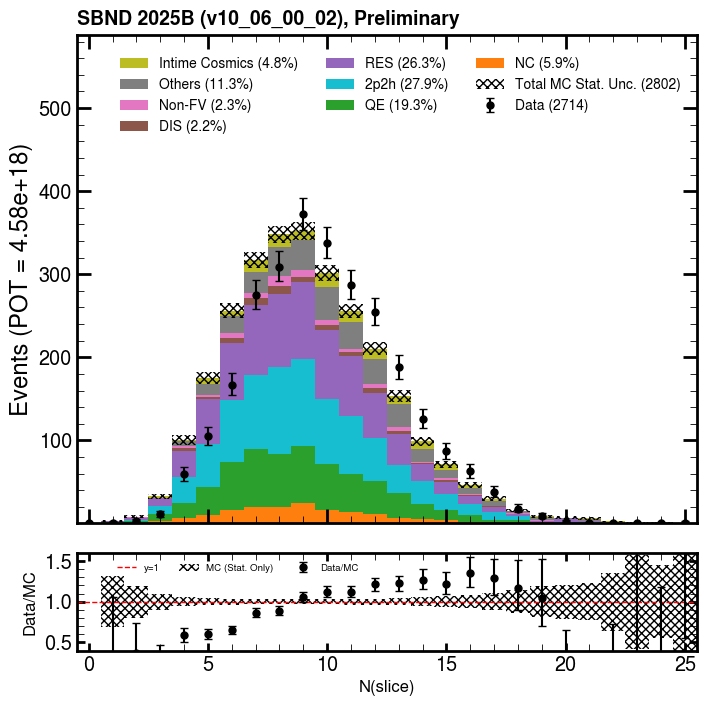

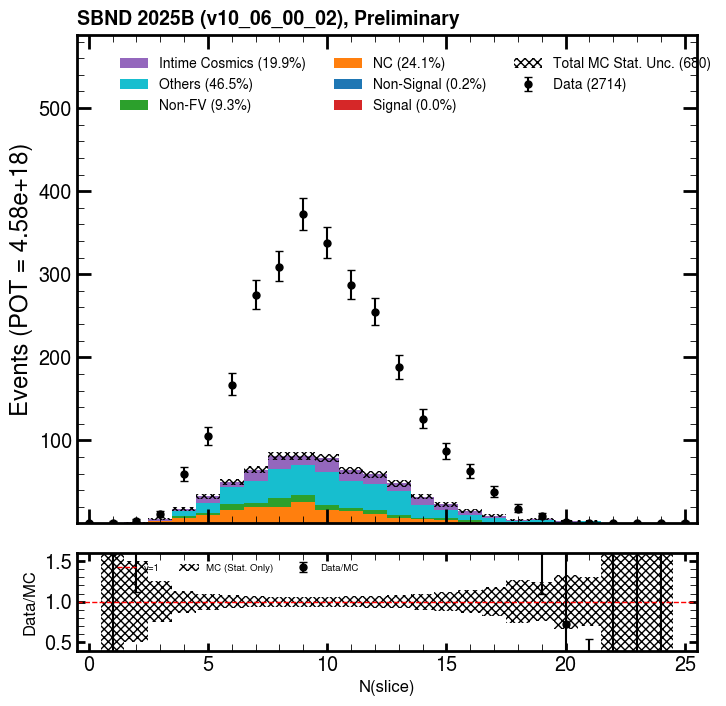

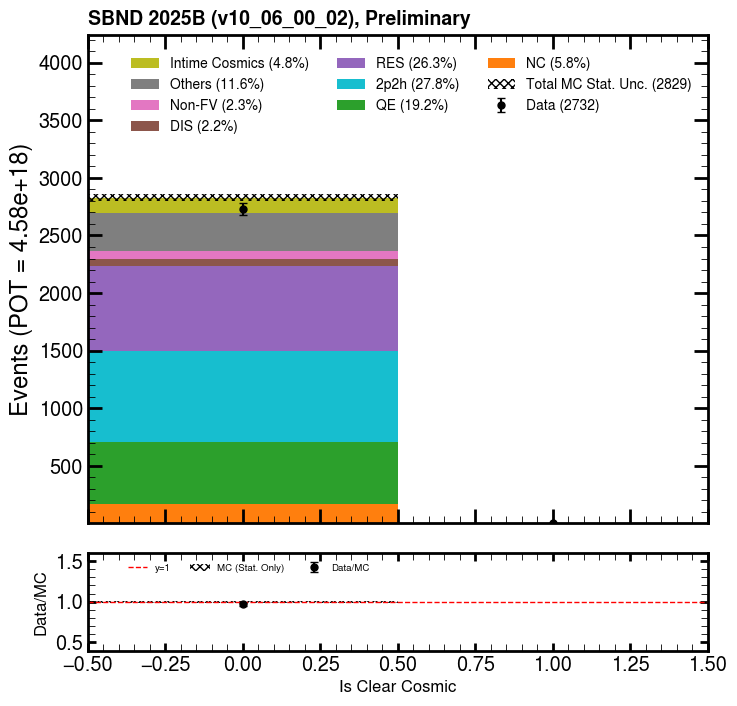

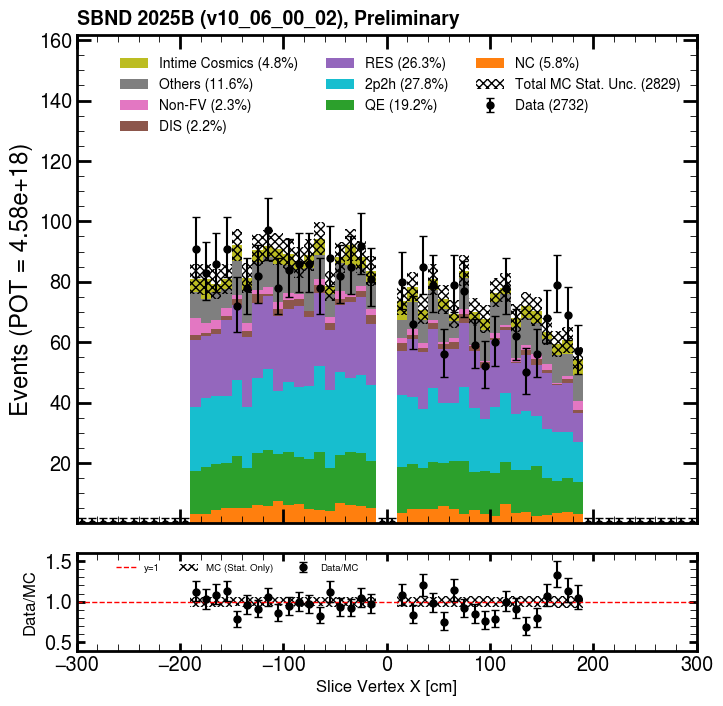

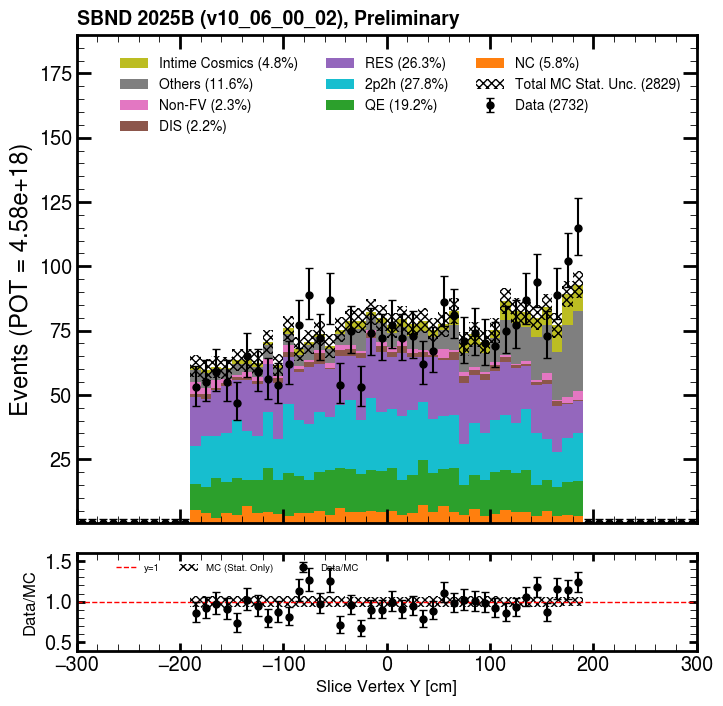

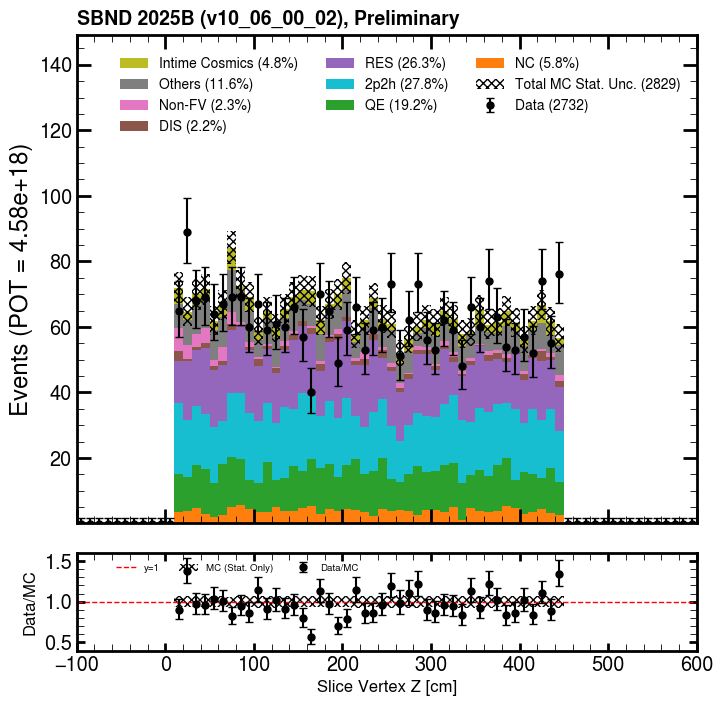

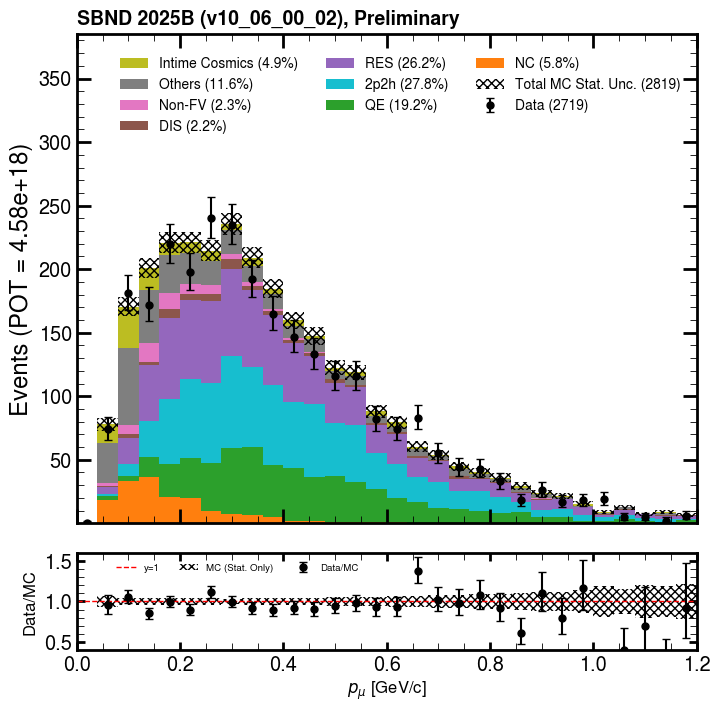

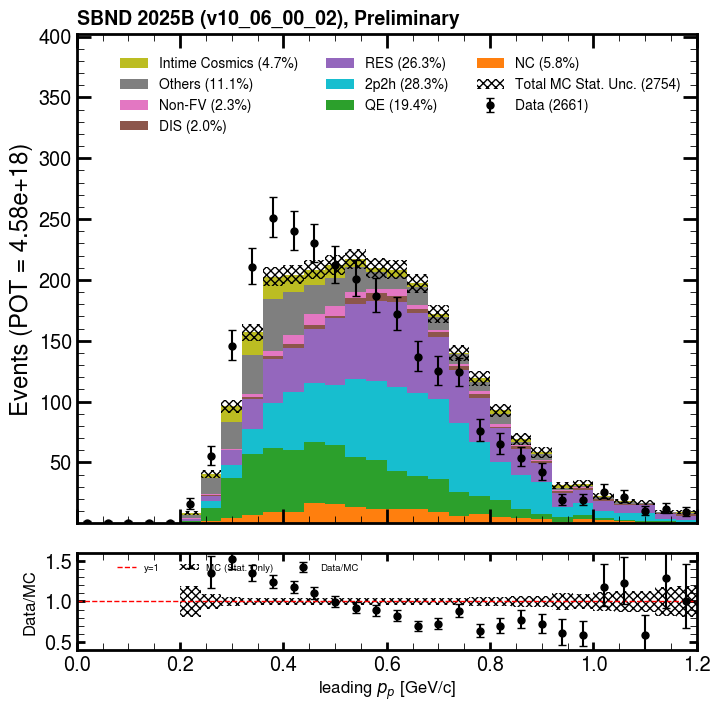

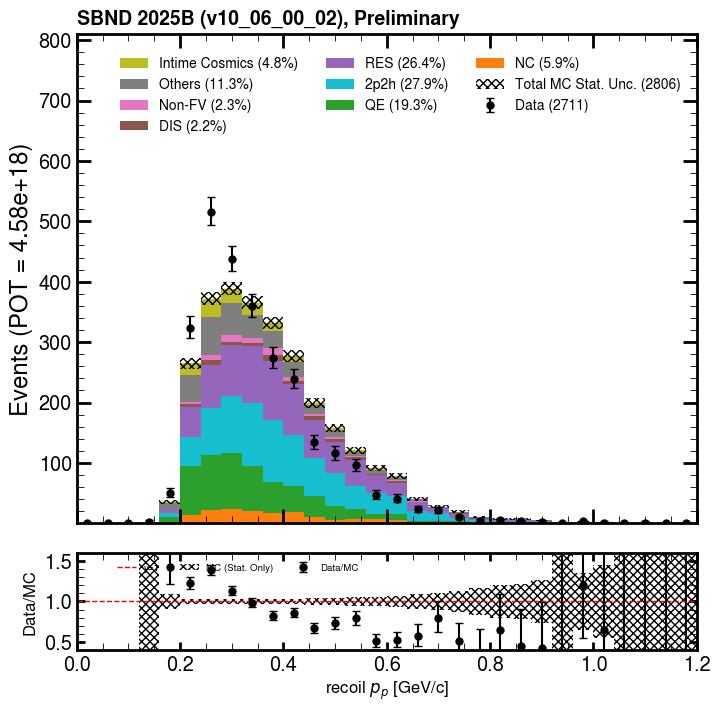

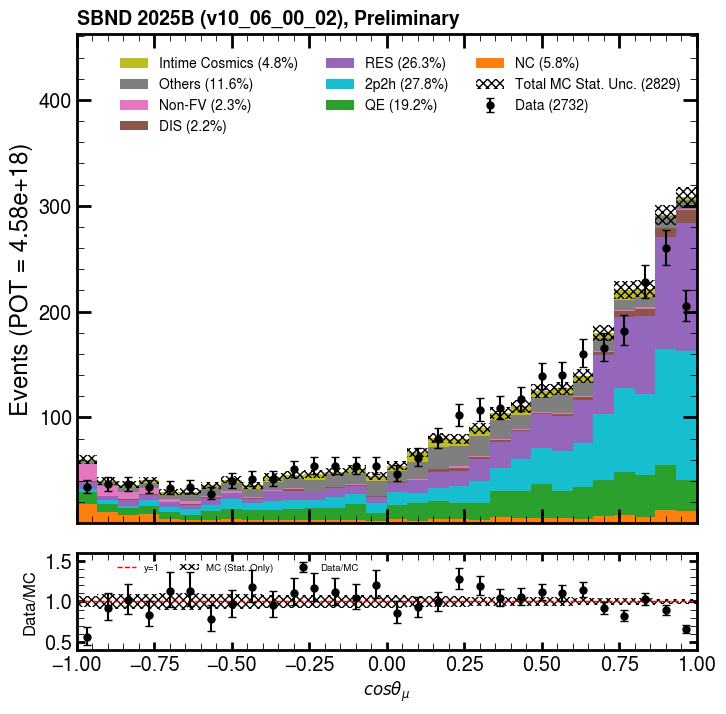

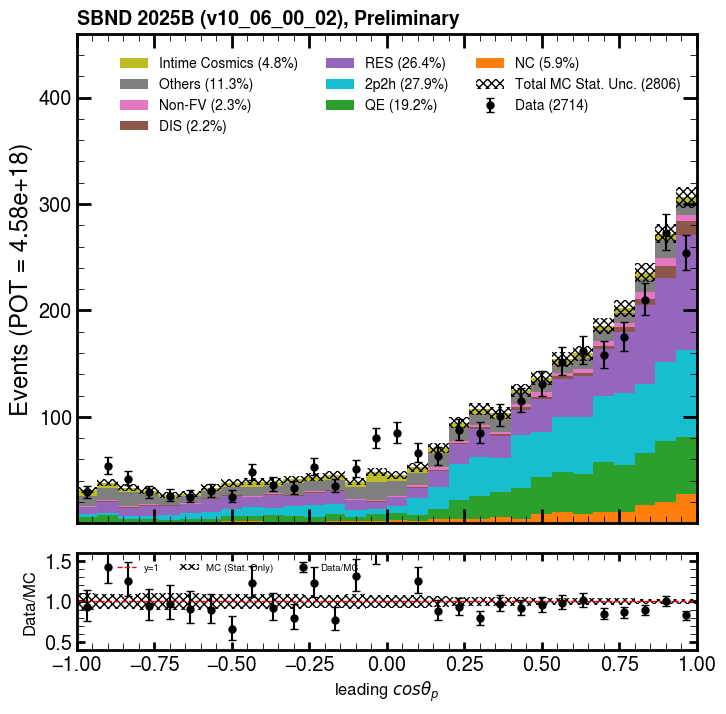

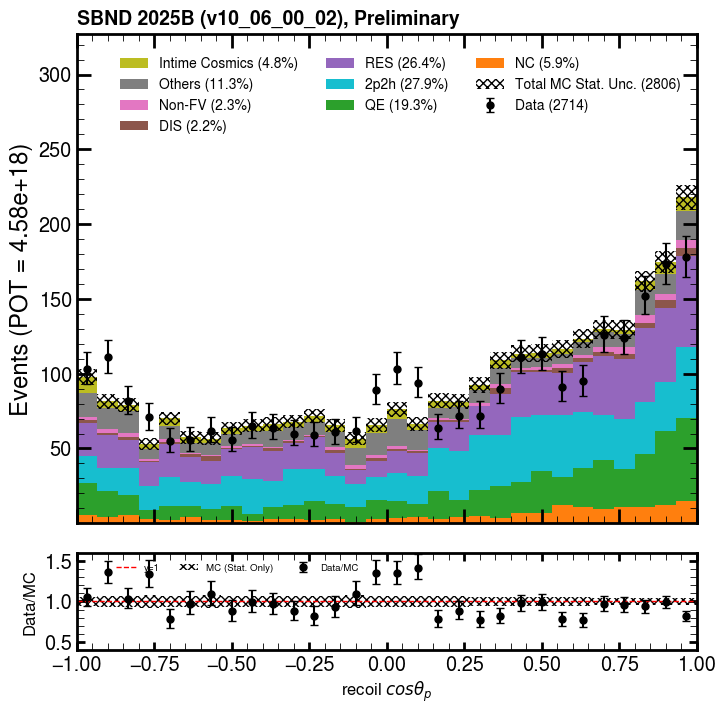

In [34]:
draw_reco_valid_plots(mc_reco_df, mc_intime_reco_df, data_reco_df, "a_vtx_fv_and_not_clear_cosmic")

In [35]:
print(data_reco_df.slc.barycenterFM.flashTime)

__ntuple  entry  rec.slc..index  rec.slc.reco.pfp..index
1         10     0               0                           -0.697868
                                 1                           -0.697868
                                 2                           -0.697868
0         13     1               0                           -0.704849
                                 1                           -0.704849
                                                               ...    
1802      43     0               1                           -0.712492
                                 2                           -0.712492
1803      17     0               0                          700.507080
                                 1                          700.507080
                                 2                          700.507080
Name: flashTime, Length: 8196, dtype: float32


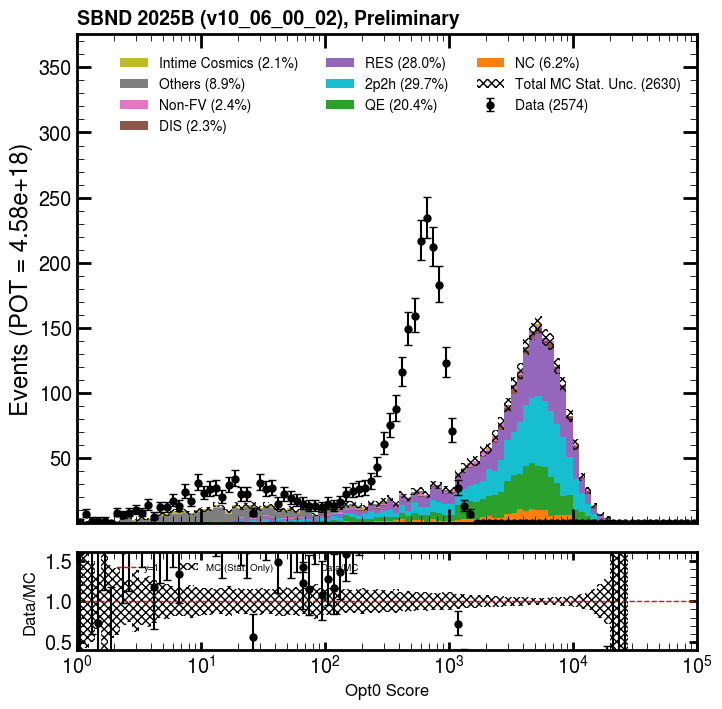

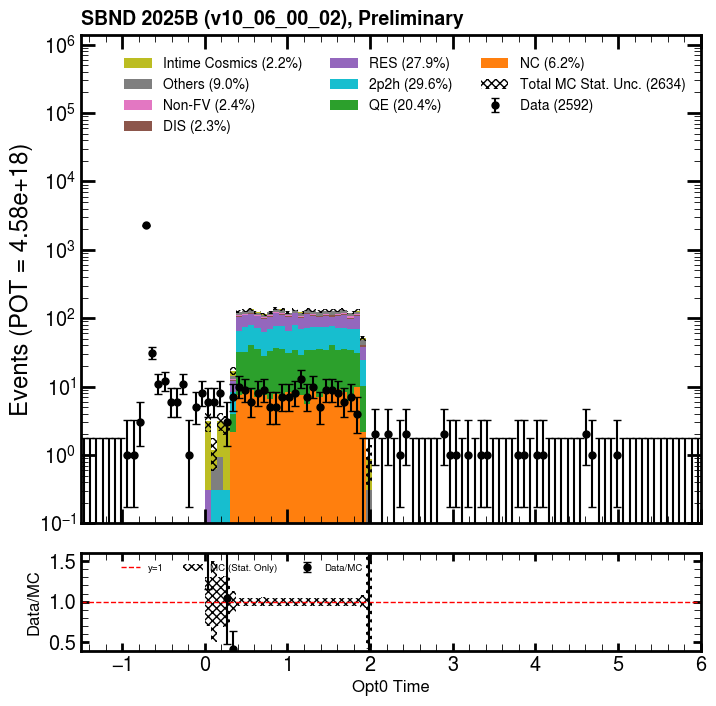

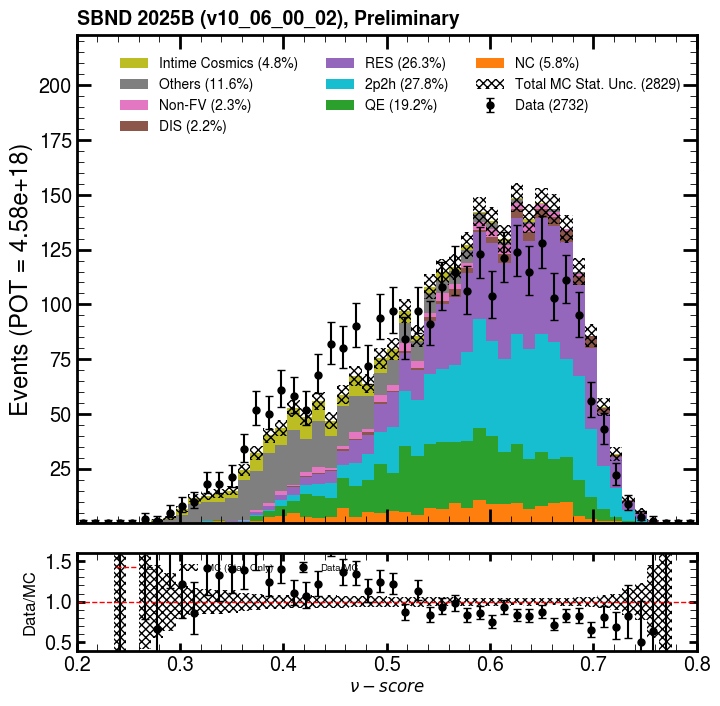

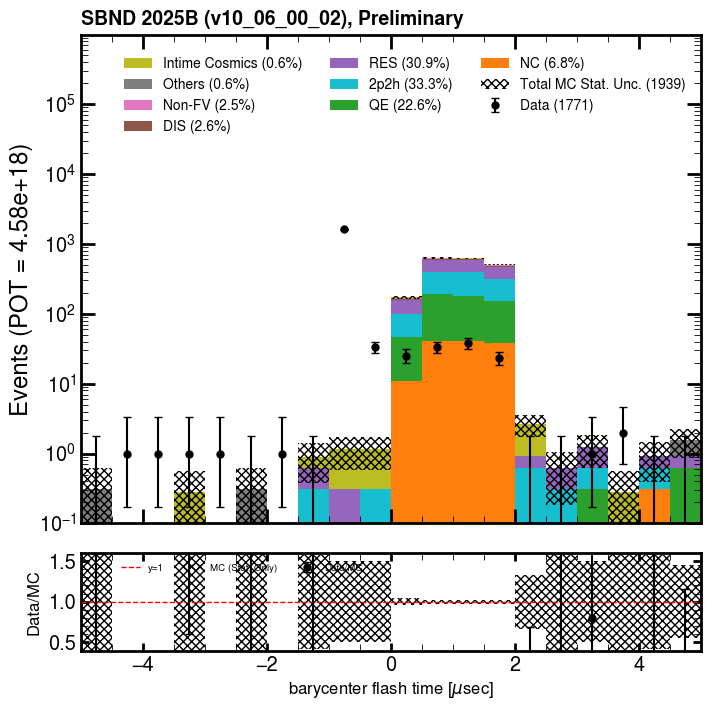

In [36]:
opt0_score_col = ('slc', 'opt0', 'score', '', '', '')
opt0_time_col = ('slc', 'opt0', 'time', '', '', '')
nuscore_col = ('slc', 'nu_score', '', '','','')
baryc_col = ('slc', 'barycenterFM', 'flashTime', '','','')

draw_mc_data_shape_comp_per_slc(mc_reco_df, mc_intime_reco_df, data_reco_df, opt0_score_col, "Opt0 Score", "A.U.", 1., 100000., 100, "a_vtx_fv_and_not_clear_cosmic_opt0_score", True, False)
draw_mc_data_shape_comp_per_slc(mc_reco_df, mc_intime_reco_df, data_reco_df, opt0_time_col, "Opt0 Time", "A.U.", -1.5, 6., 100, "a_vtx_fv_and_not_clear_cosmic_opt0_time", False, True)
draw_mc_data_shape_comp_per_slc(mc_reco_df, mc_intime_reco_df, data_reco_df, nuscore_col, "$\\nu-score$", "A.U.", 0.2, 0.8, 50, "a_vtx_fv_and_not_clear_cosmic_nuscore", False, False)
draw_mc_data_shape_comp_per_slc(mc_reco_df, mc_intime_reco_df, data_reco_df, baryc_col, "barycenter flash time [$\mu$sec]", "A.U.", -5., 5, 20, "a_vtx_fv_and_not_clear_cosmic_nuscore", False, True)

In [37]:
## 3) n trk with len > 4 cm and vtx dist < 6 cm
mc_reco_df = mc_reco_df[(mc_reco_df.pfp.trk.len > 4.) & (mc_reco_df.pfp.dist_to_vertex < 6.)]
mc_intime_reco_df = mc_intime_reco_df[(mc_intime_reco_df.pfp.trk.len > 4.) & (mc_intime_reco_df.pfp.dist_to_vertex < 6.)]
data_reco_df = data_reco_df[(data_reco_df.pfp.trk.len > 4.) & (data_reco_df.pfp.dist_to_vertex < 6.)]

#### exactly 3 pfps
mc_reco_df = pass_slc_with_n_pfps(mc_reco_df)
mc_intime_reco_df = pass_slc_with_n_pfps(mc_intime_reco_df)
data_reco_df = pass_slc_with_n_pfps(data_reco_df)

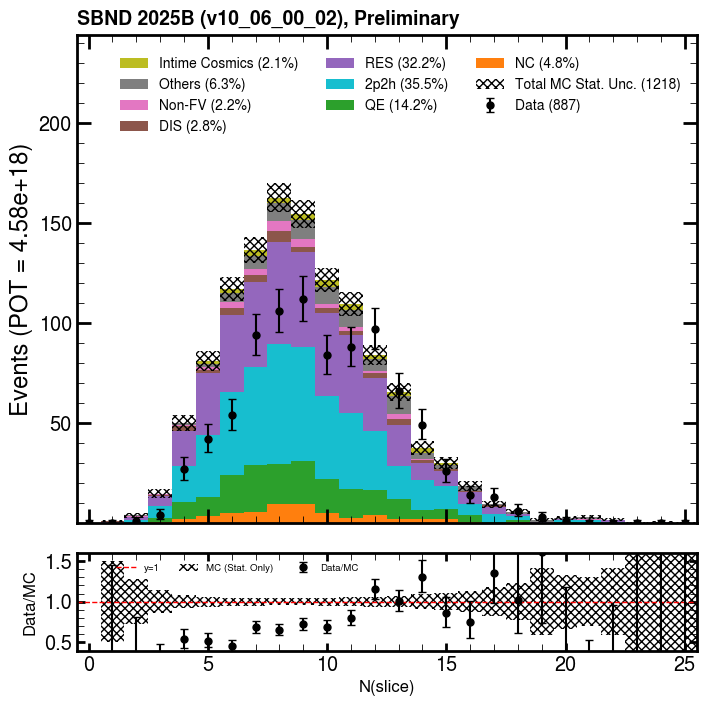

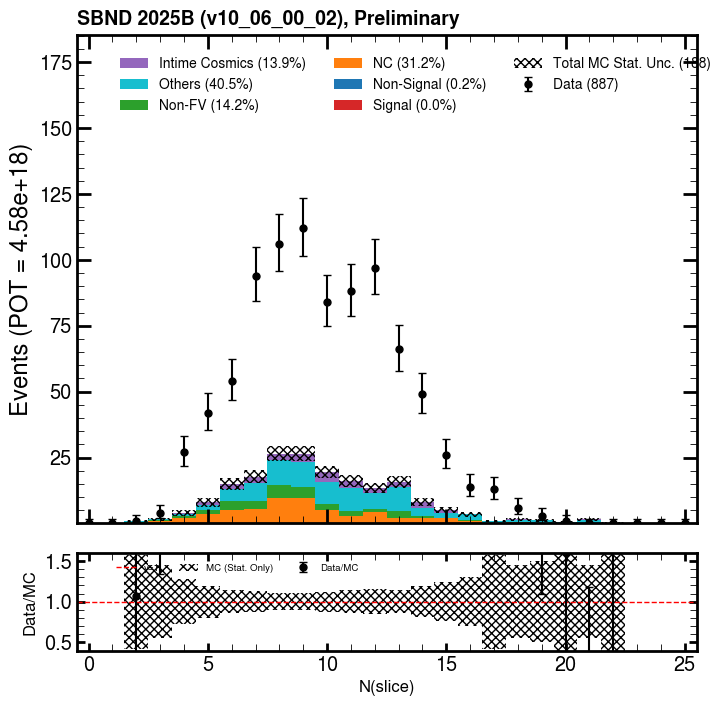

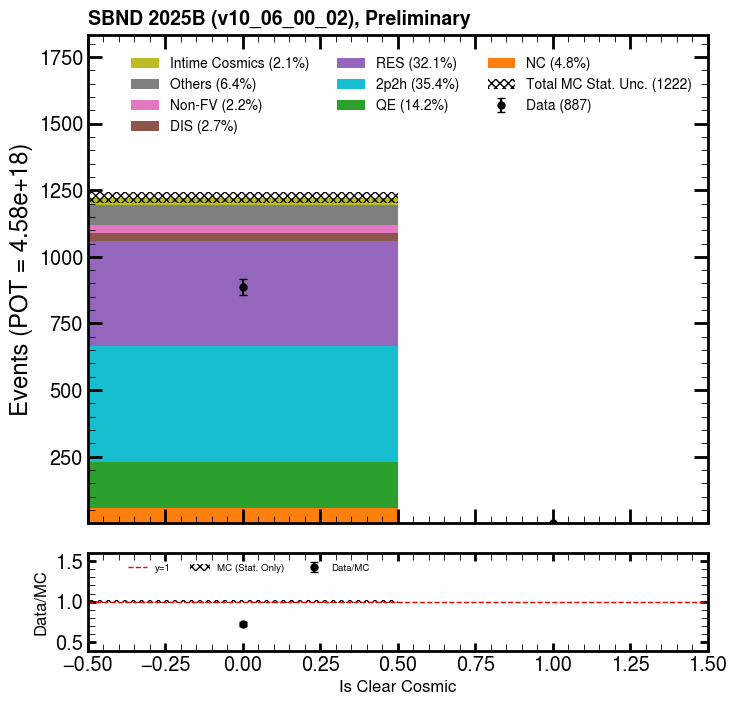

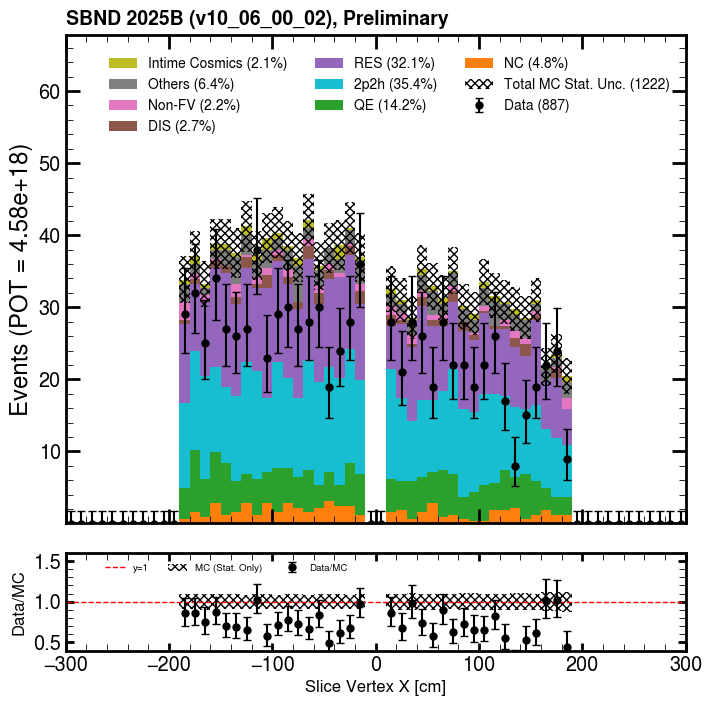

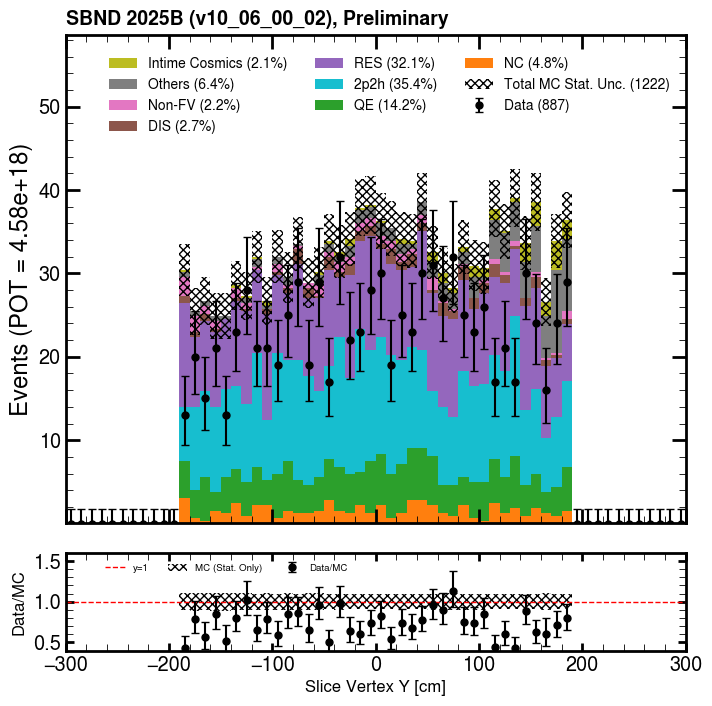

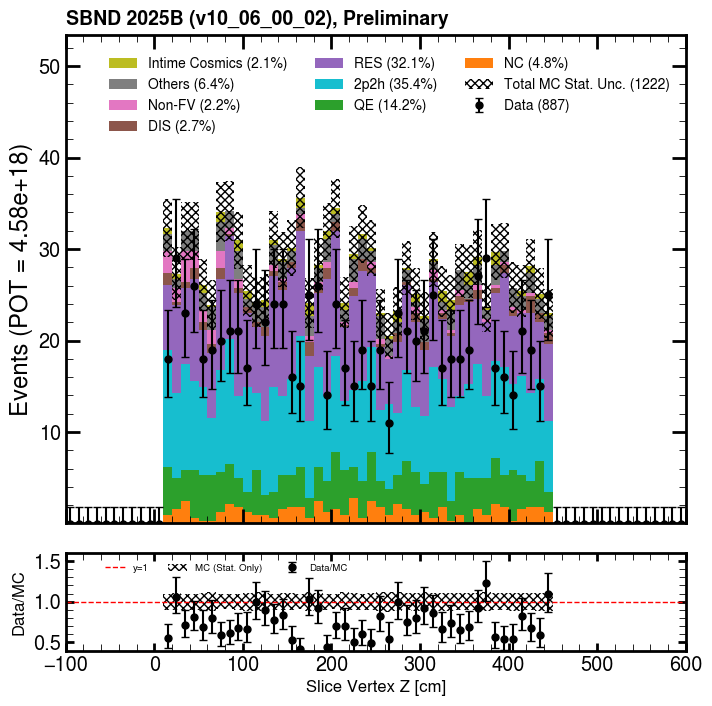

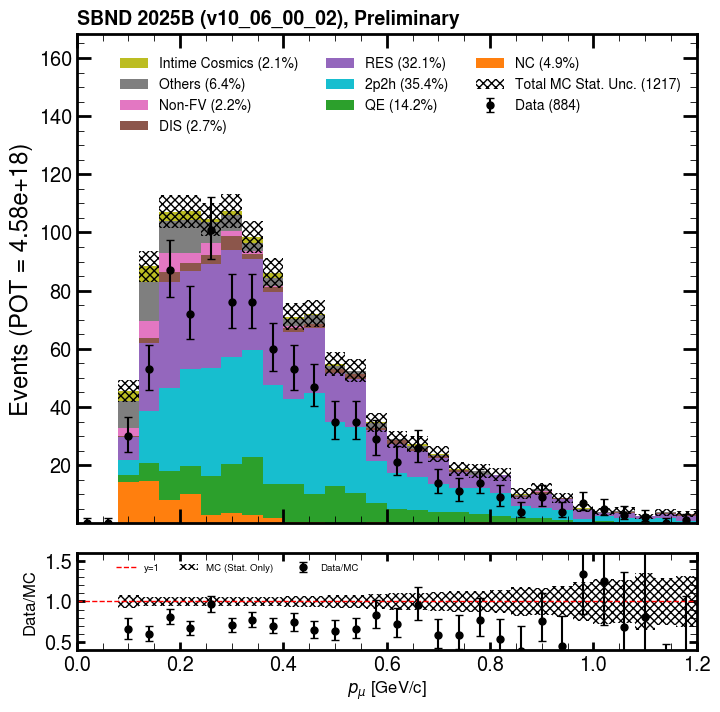

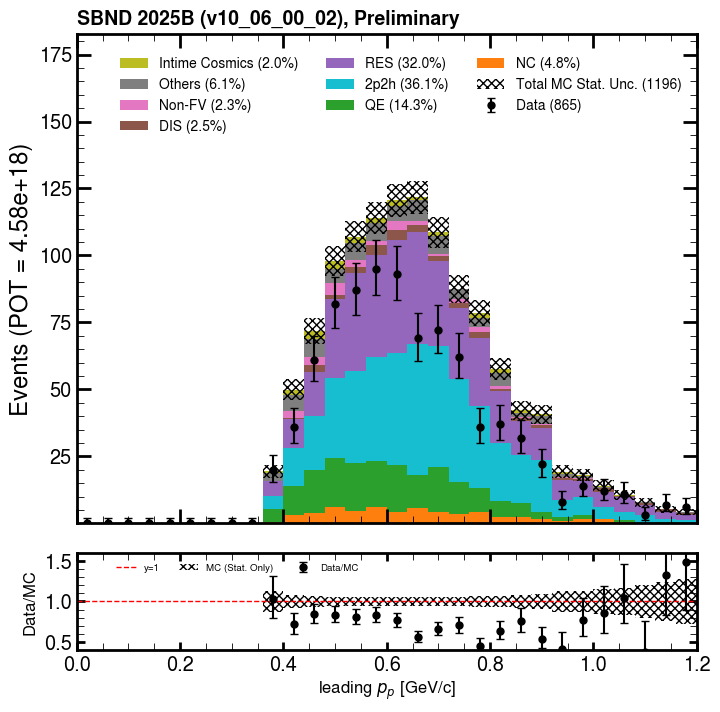

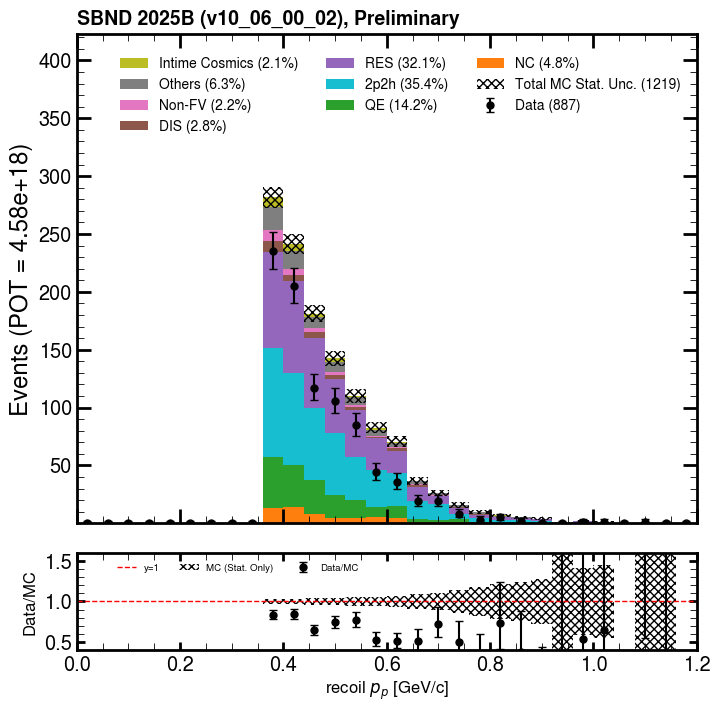

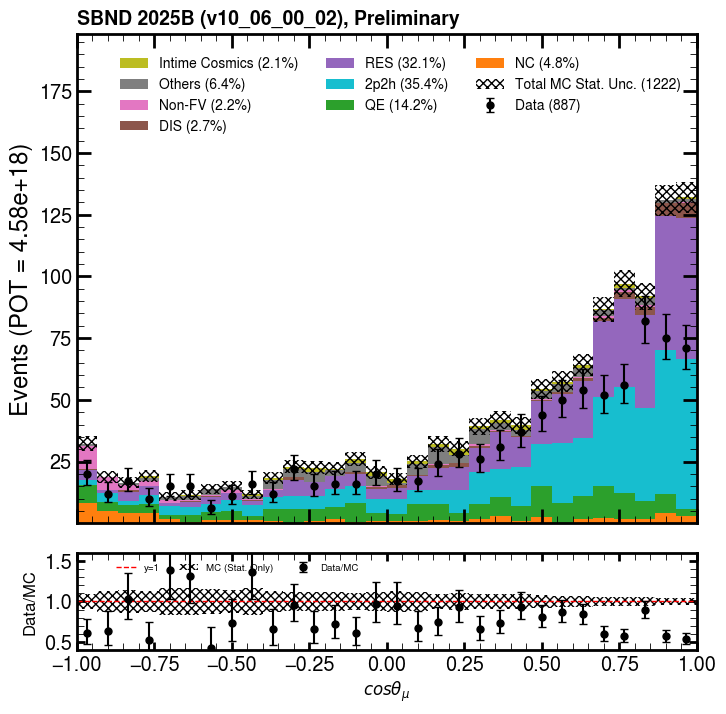

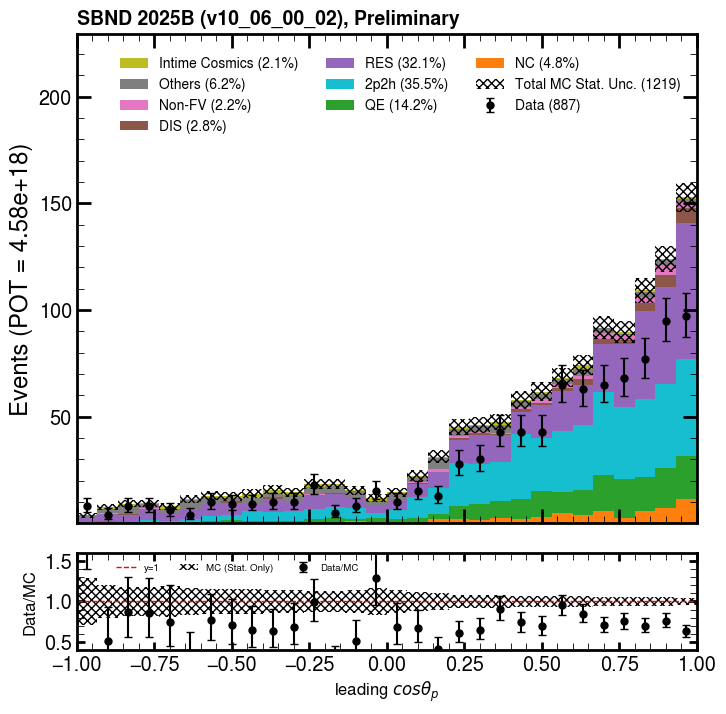

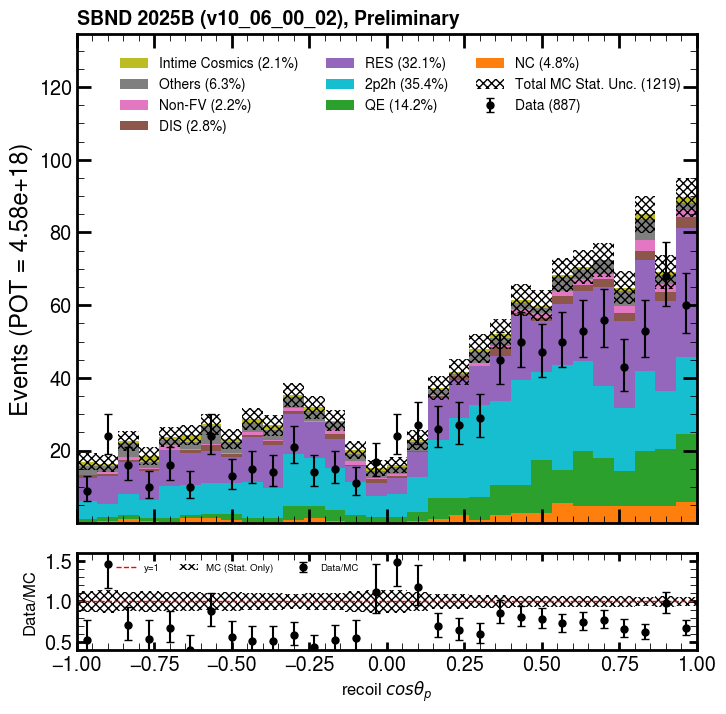

In [38]:
draw_reco_valid_plots(mc_reco_df, mc_intime_reco_df, data_reco_df, "c_n_trk_len_and_distvtx")

In [39]:
## 4) trk score > 0.5
mc_reco_df = mc_reco_df[(mc_reco_df.pfp.trackScore > 0.5)]
mc_intime_reco_df = mc_intime_reco_df[(mc_intime_reco_df.pfp.trackScore > 0.5)]
data_reco_df = data_reco_df[(data_reco_df.pfp.trackScore > 0.5)]

#### exactly 3 pfps
mc_reco_df = pass_slc_with_n_pfps(mc_reco_df)
mc_intime_reco_df = pass_slc_with_n_pfps(mc_intime_reco_df)
data_reco_df = pass_slc_with_n_pfps(data_reco_df)

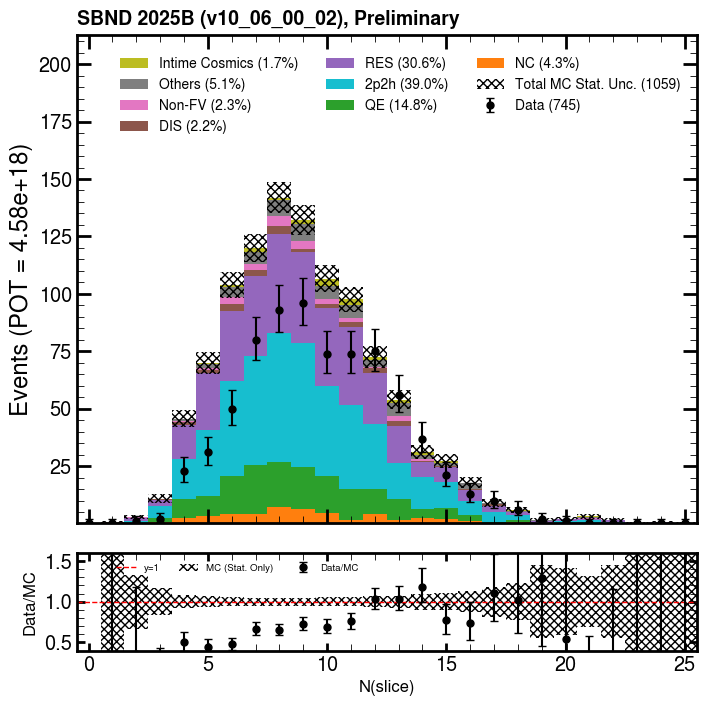

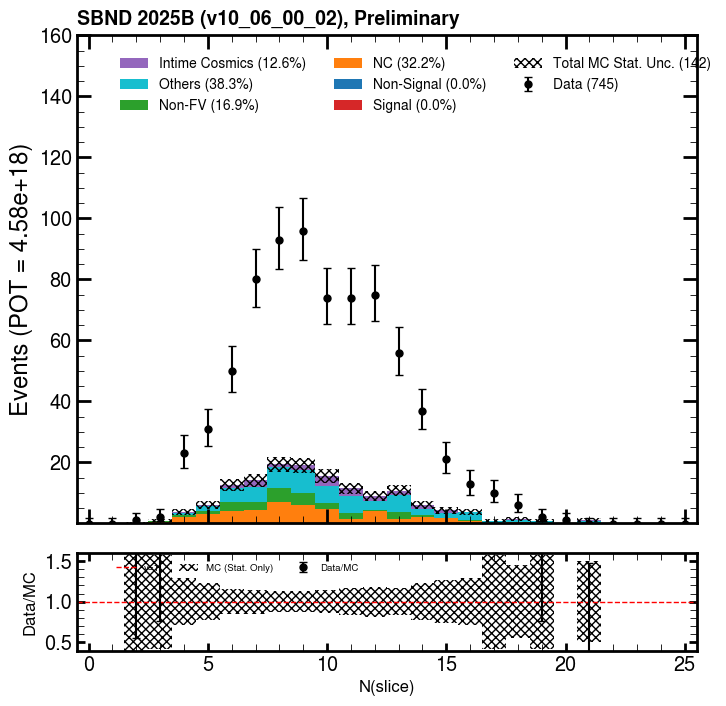

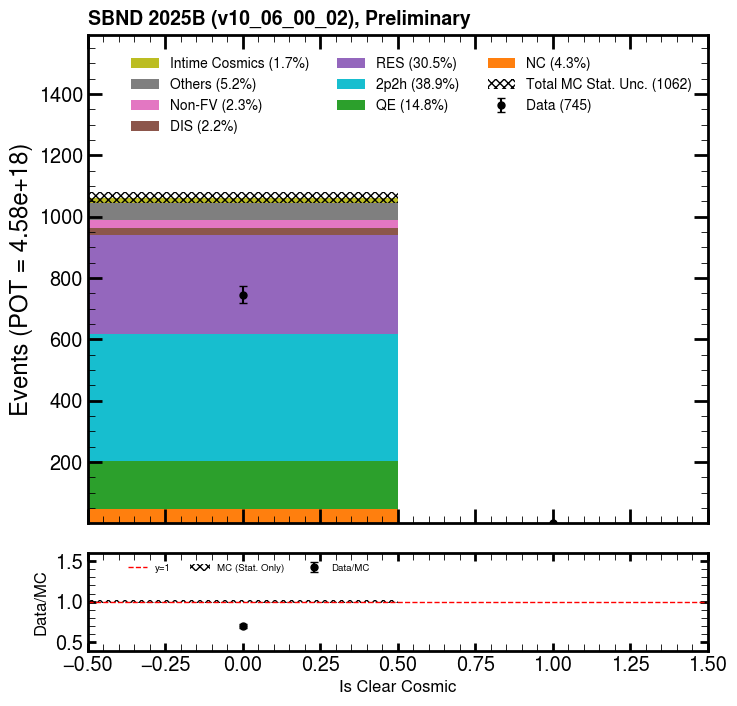

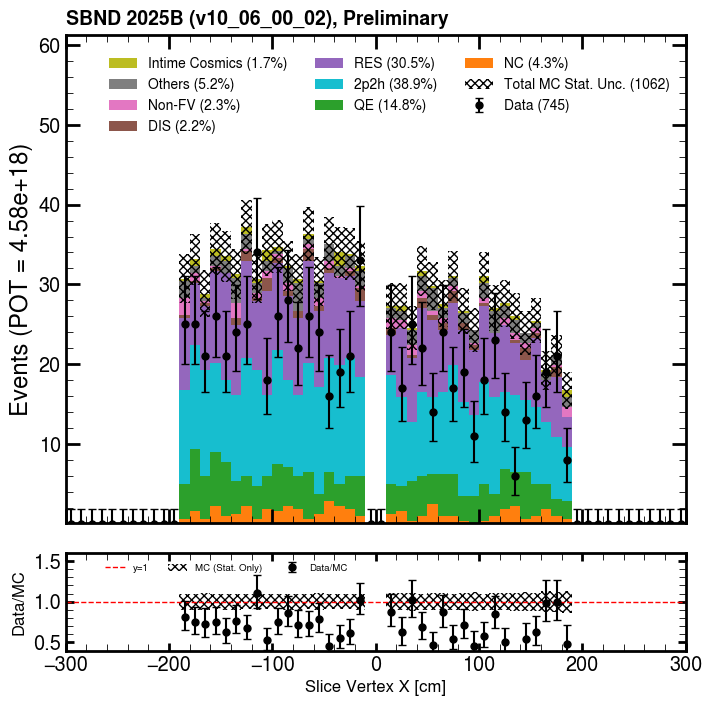

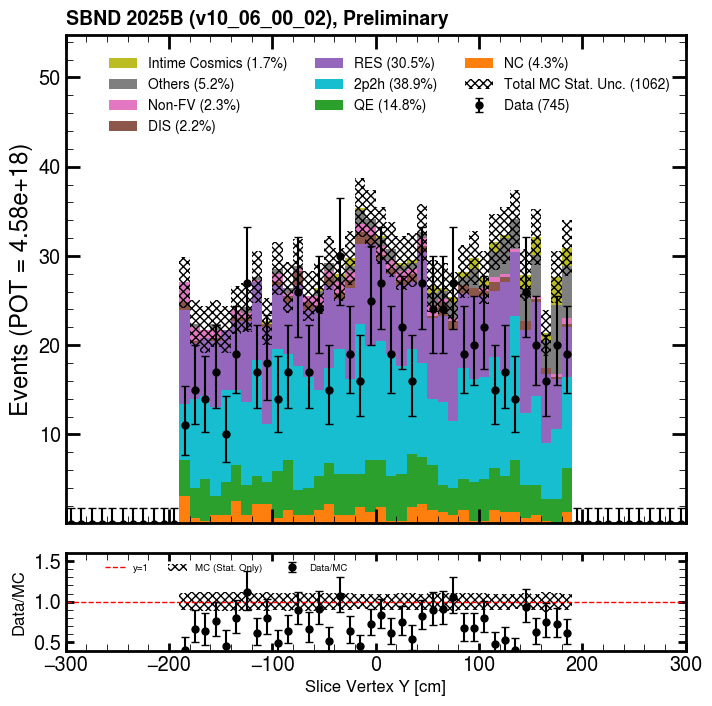

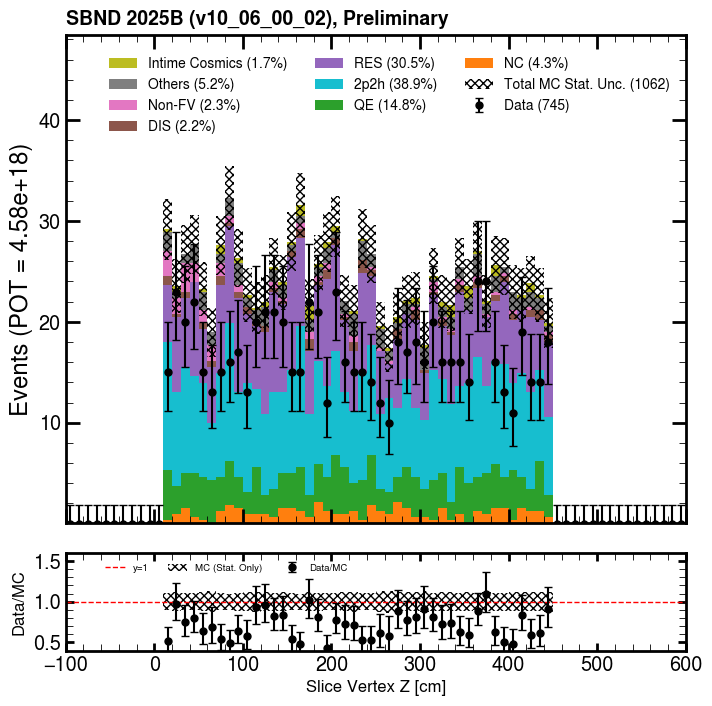

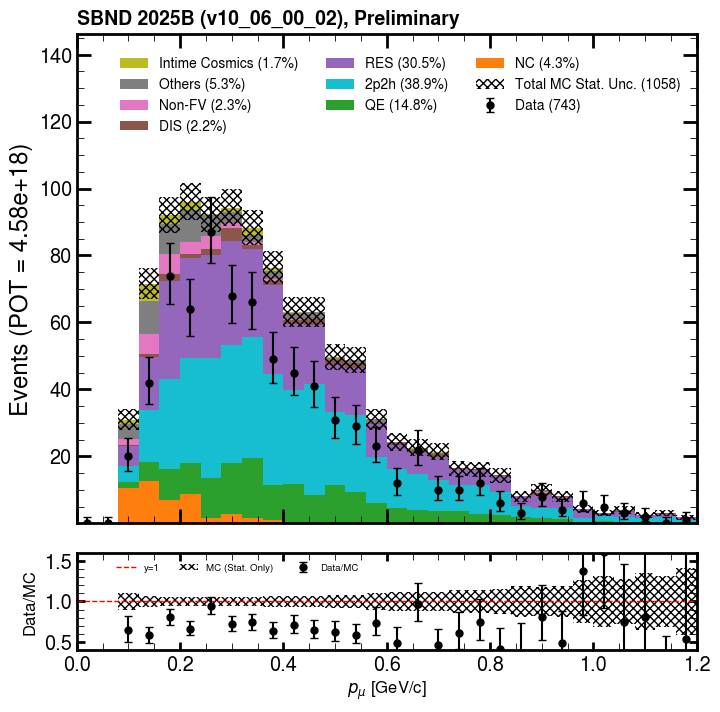

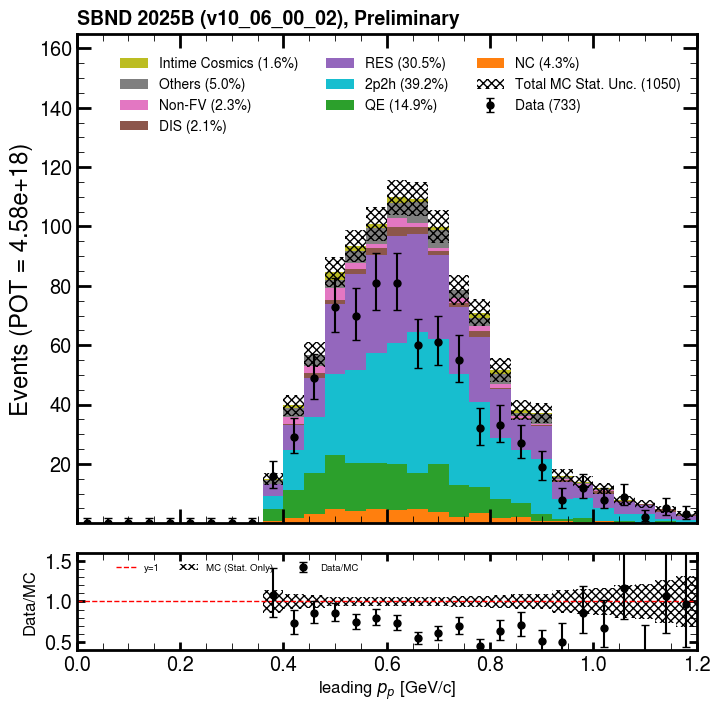

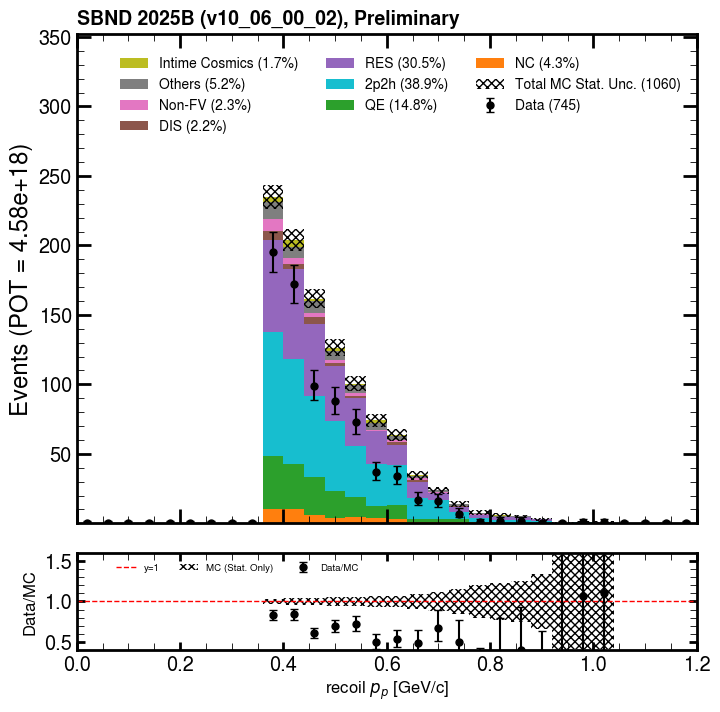

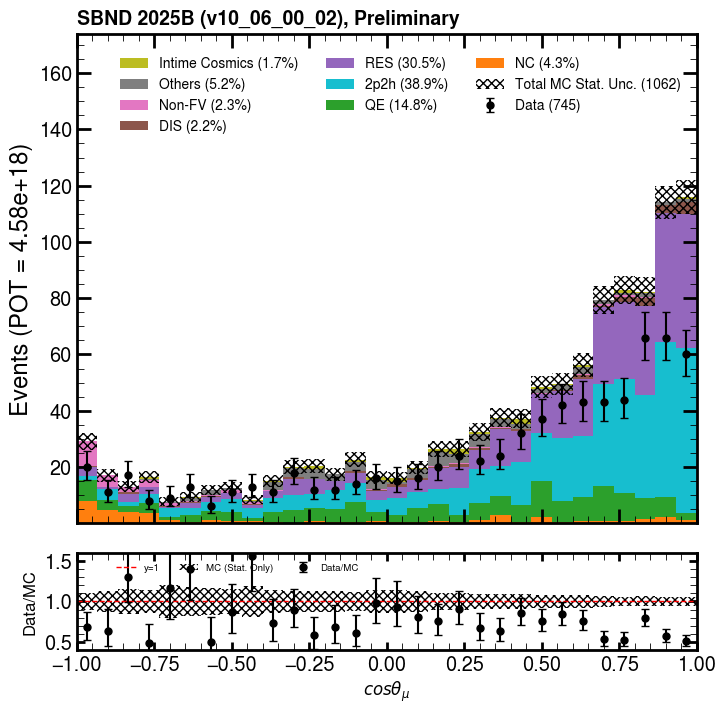

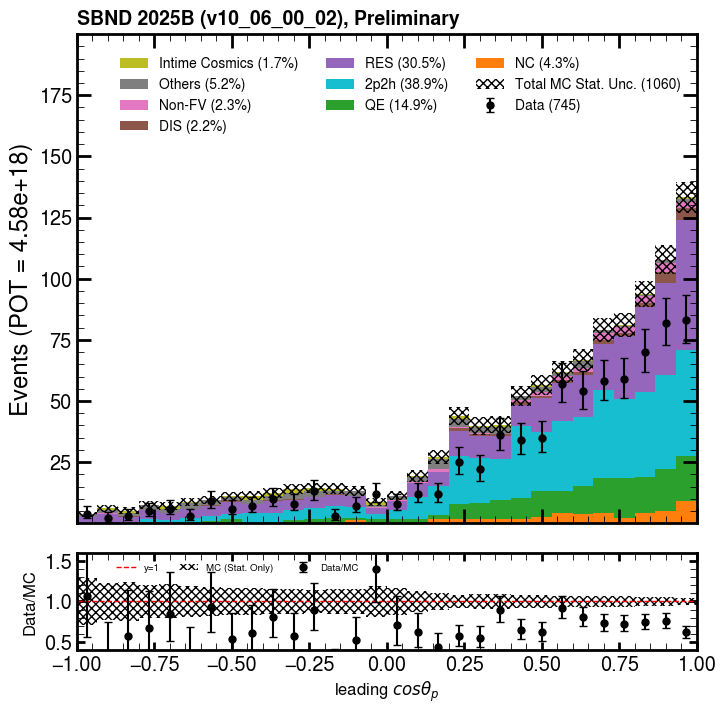

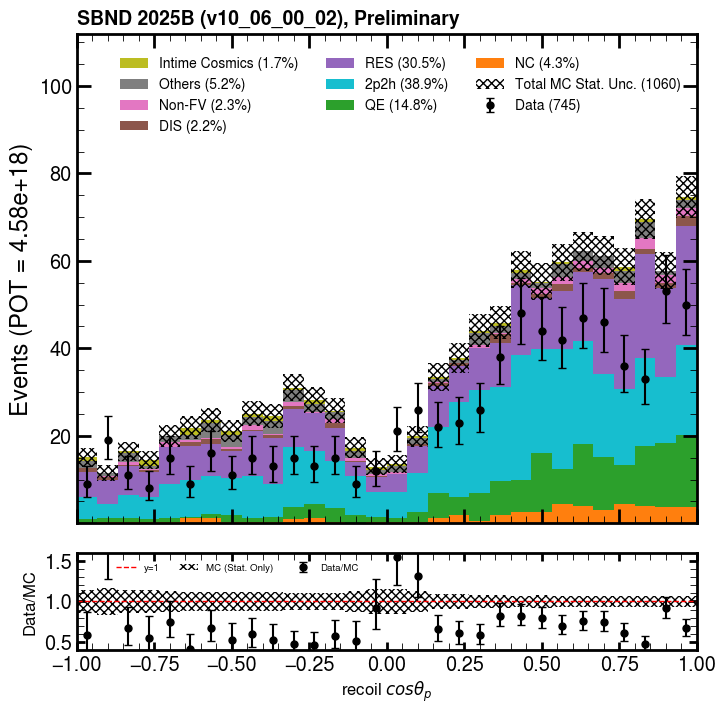

In [40]:
draw_reco_valid_plots(mc_reco_df, mc_intime_reco_df, data_reco_df, "d_n_trk_score_0p5")

In [41]:
def reco_imbalance(muon_dir_x, muon_dir_y, muon_dir_z, range_P_muon, 
                 lead_proton_dir_x, lead_proton_dir_y, lead_proton_dir_z, lead_range_P_proton,
                 rec_proton_dir_x, rec_proton_dir_y, rec_proton_dir_z, rec_range_P_proton):

    # deltapt
    deltapt_x = muon_dir_x.iloc[0] * range_P_muon.iloc[0] + lead_proton_dir_x.iloc[0] * lead_range_P_proton.iloc[0] + rec_proton_dir_x.iloc[0] * rec_range_P_proton.iloc[0]
    px_sq = np.power(deltapt_x, 2.)
    deltapt_y = muon_dir_y.iloc[0] * range_P_muon.iloc[0] + lead_proton_dir_y.iloc[0] * lead_range_P_proton.iloc[0] + rec_proton_dir_y.iloc[0] * rec_range_P_proton.iloc[0]
    py_sq = np.power(deltapt_y, 2.)
    deltapt = np.sqrt(px_sq + py_sq)

    # deltaalphat
    muon_px = muon_dir_x.iloc[0] * range_P_muon.iloc[0]
    muon_py = muon_dir_y.iloc[0] * range_P_muon.iloc[0]
    muon_pz = muon_dir_z.iloc[0] * range_P_muon.iloc[0]    
    muon_pt = np.sqrt( np.power(muon_px,2.) + np.power(muon_py,2.) ) 
    muon_p = range_P_muon.iloc[0]
    deltaalphat_denom = muon_pt * deltapt
    deltaalphat_num = - ( muon_px * deltapt_x + muon_py * deltapt_y ) 
    deltaalphat = np.arccos( deltaalphat_num / deltaalphat_denom) * 180./np.pi
    
    #deltaphit
    lead_proton_x = lead_proton_dir_x.iloc[0] * lead_range_P_proton.iloc[0] 
    rec_proton_x = rec_proton_dir_x.iloc[0] * rec_range_P_proton.iloc[0]     
    proton_px = lead_proton_x + rec_proton_x
    
    lead_proton_y = lead_proton_dir_y.iloc[0] * lead_range_P_proton.iloc[0] 
    rec_proton_y = rec_proton_dir_y.iloc[0] * rec_range_P_proton.iloc[0]     
    proton_py = lead_proton_y + rec_proton_y
    
    lead_proton_z = lead_proton_dir_z.iloc[0] * lead_range_P_proton.iloc[0] 
    rec_proton_z = rec_proton_dir_z.iloc[0] * rec_range_P_proton.iloc[0]    
    proton_pz = lead_proton_z + rec_proton_z    

    proton_pt = np.sqrt( np.power(proton_px,2.) + np.power(proton_py,2.) )   
    proton_p = np.sqrt( np.power(proton_px,2.) + np.power(proton_py,2.) + np.power(proton_pz,2.) )      
    lead_proton_p = np.sqrt( np.power(lead_proton_x,2.) + np.power(lead_proton_y,2.) + np.power(lead_proton_z,2.) )
    rec_proton_p = np.sqrt( np.power(rec_proton_x,2.) + np.power(rec_proton_y,2.) + np.power(rec_proton_z,2.) )
      
    deltaphit_denom = muon_pt * proton_pt
    deltaphit_num = - ( muon_px * proton_px + muon_py * proton_py )
    deltaphit = np.arccos(deltaphit_num / deltaphit_denom) * 180./np.pi
    
    # cos(theta_LR)
    costheta_lr_num = lead_proton_x * rec_proton_x + lead_proton_y * rec_proton_y + lead_proton_z * rec_proton_z
    costheta_lr_denom = lead_range_P_proton.iloc[0] * rec_range_P_proton.iloc[0]
    costheta_lr = costheta_lr_num / costheta_lr_denom
    
    # costheta_mu_sum
    costheta_mu_sum_num = muon_px * proton_px + muon_py * proton_py + muon_pz * proton_pz
    costheta_mu_sum_denom = muon_p * proton_p
    costheta_mu_sum = costheta_mu_sum_num / costheta_mu_sum_denom
        
    #e_cal
    e_mu = np.sqrt( np.power(muon_p,2.) + np.power(0.105,2) )
    e_lead_p = np.sqrt( np.power(lead_proton_p,2.) + np.power(0.938272,2) )
    ke_lead_p = e_lead_p - 0.938272
    e_rec_p = np.sqrt( np.power(rec_proton_p,2.) + np.power(0.938272,2) )
    ke_rec_p = e_rec_p - 0.938272    
    e_cal = e_mu + ke_lead_p + ke_rec_p + 0.0309 # https://link.springer.com/article/10.1140/epjc/s10052-019-6750-3
    
    #p_l
    p_l = muon_pz + proton_pz - e_cal
    
    #pn
    pn = np.sqrt( np.power(p_l,2.) + np.power(deltapt,2.) )
    pn_x = deltapt_x
    pn_y = deltapt_y
    pn_z = p_l
    
    # q (energy transfer)
    q_x = - muon_px
    q_y = - muon_py
    q_z = - muon_pz + e_cal
    q = np.sqrt( np.power(q_x,2.) + np.power(q_y,2.) + np.power(q_z,2.) )
    
    # phi_3d
    phi_3d_num = q_x * proton_px + q_y * proton_py + q_z * proton_pz
    phi_3d_denom = q * proton_p
    phi_3d = np.arccos(phi_3d_num / phi_3d_denom) * 180./np.pi
    
    #alpha_3d
    alpha_3d_num = q_x * pn_x + q_y * pn_y + q_z * pn_z
    alpha_3d_denom = q * pn
    alpha_3d = np.arccos(alpha_3d_num / alpha_3d_denom) * 180./np.pi
    
    return pd.Series({
                    'deltapt': deltapt,
                    'deltaalphat': deltaalphat,
                    'deltaphit': deltaphit,
                    'costheta_lr':costheta_lr,
                    'costheta_mu_sum':costheta_mu_sum,
                    'e_cal': e_cal,
                    'pn':pn,
                    'phi_3d': phi_3d,
                    'alpha_3d': alpha_3d         
                    })

def measure_reco_imbalance(group):
    
    muons = group[group.pfp.trk.reco_pid == 13]
    protons = group[group.pfp.trk.reco_pid == 2212]    
    
    lead_protons = protons.sort_values(by=("pfp", "trk", "len", "", "", ""), ascending=False).groupby(level=[0,1]).nth(0)
    rec_protons = protons.sort_values(by=("pfp", "trk", "len", "", "", ""), ascending=False).groupby(level=[0,1]).nth(1)    
    
    muon_dir_x = muons[('pfp', 'trk', 'dir', 'x', '', '')]
    muon_dir_y = muons[('pfp', 'trk', 'dir', 'y', '', '')]
    muon_dir_z = muons[('pfp', 'trk', 'dir', 'z', '', '')]
    muon_range = muons[('pfp', 'trk', 'rangeP', 'p_muon', '', '')]
    
    lead_proton_dir_x = lead_protons[('pfp', 'trk', 'dir', 'x', '', '')]
    lead_proton_dir_y = lead_protons[('pfp', 'trk', 'dir', 'y', '', '')]
    lead_proton_dir_z = lead_protons[('pfp', 'trk', 'dir', 'z', '', '')]
    lead_proton_range = lead_protons[('pfp', 'trk', 'rangeP', 'p_proton', '', '')]
 
    rec_proton_dir_x = rec_protons[('pfp', 'trk', 'dir', 'x', '', '')]
    rec_proton_dir_y = rec_protons[('pfp', 'trk', 'dir', 'y', '', '')]
    rec_proton_dir_z = rec_protons[('pfp', 'trk', 'dir', 'z', '', '')]
    rec_proton_range = rec_protons[('pfp', 'trk', 'rangeP', 'p_proton', '', '')]        
    
    return reco_imbalance(muon_dir_x, muon_dir_y, muon_dir_z, muon_range, 
                        lead_proton_dir_x, lead_proton_dir_y, lead_proton_dir_z, lead_proton_range,
                        rec_proton_dir_x, rec_proton_dir_y, rec_proton_dir_z, rec_proton_range)  

In [42]:
## study if track contained
add_contained_col(mc_reco_df)
add_contained_col(mc_intime_reco_df)
add_contained_col(data_reco_df)

In [43]:
mc_reco_df = mc_reco_df[mc_reco_df.pfp.contained]
mc_intime_reco_df = mc_intime_reco_df[mc_intime_reco_df.pfp.contained]
data_reco_df = data_reco_df[data_reco_df.pfp.contained]

#### exactly 3 pfps
mc_reco_df = pass_slc_with_n_pfps(mc_reco_df)
mc_intime_reco_df = pass_slc_with_n_pfps(mc_intime_reco_df)
data_reco_df = pass_slc_with_n_pfps(data_reco_df)

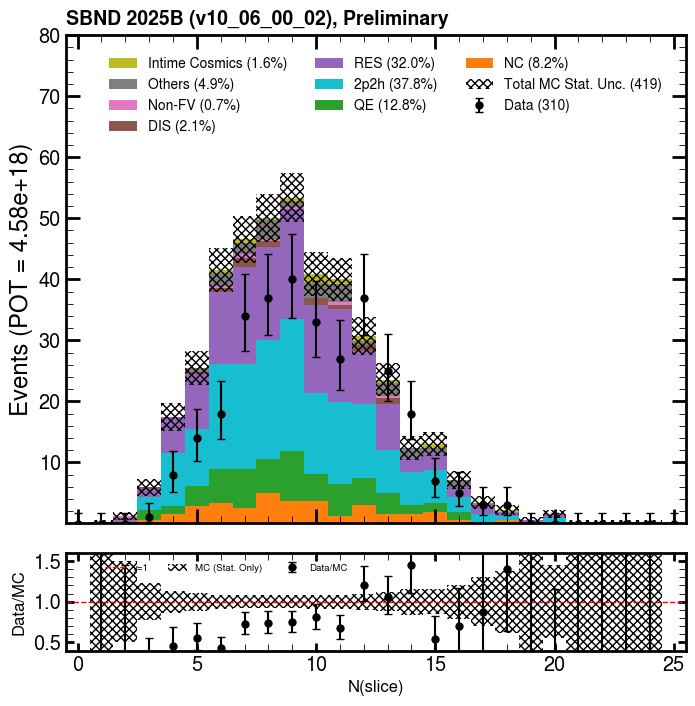

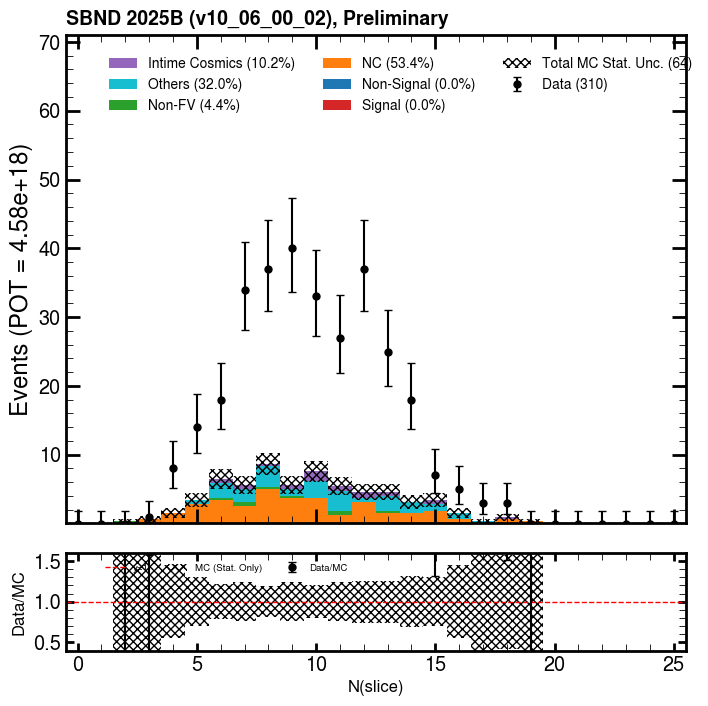

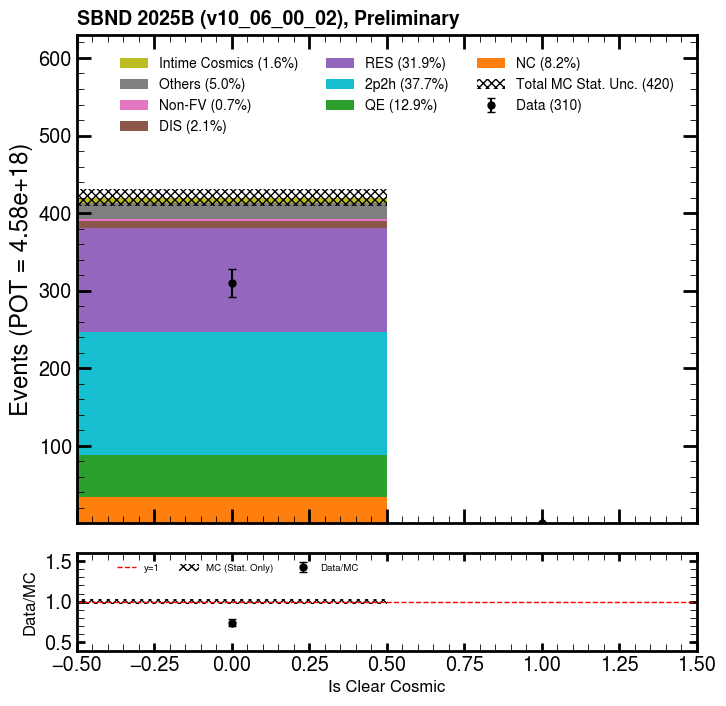

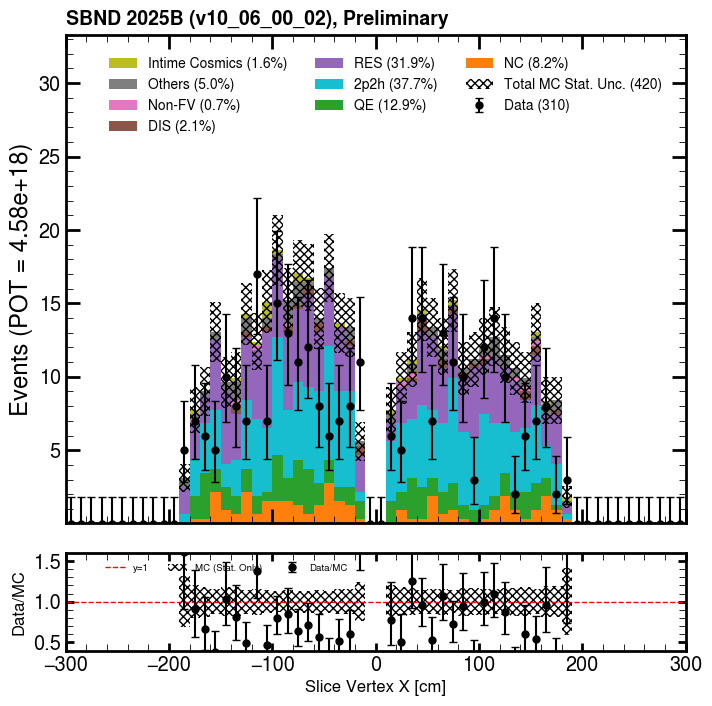

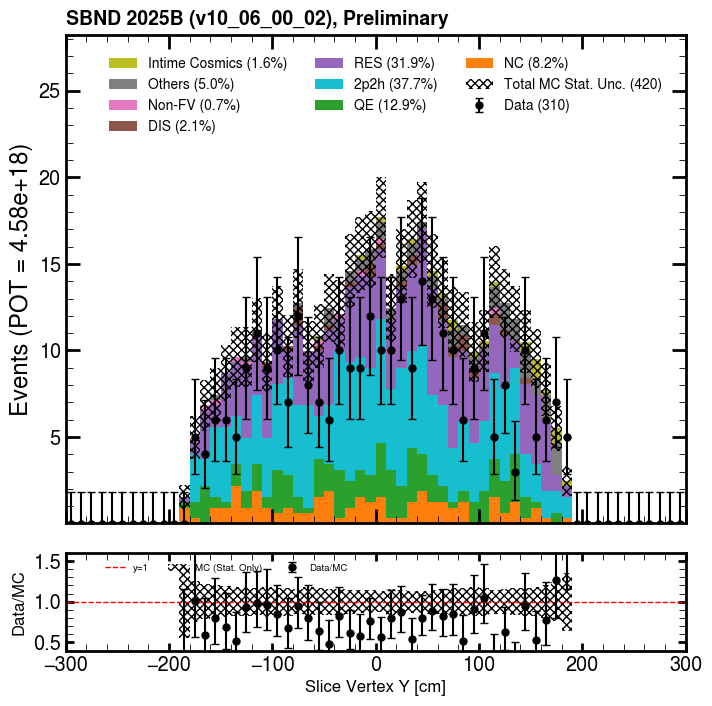

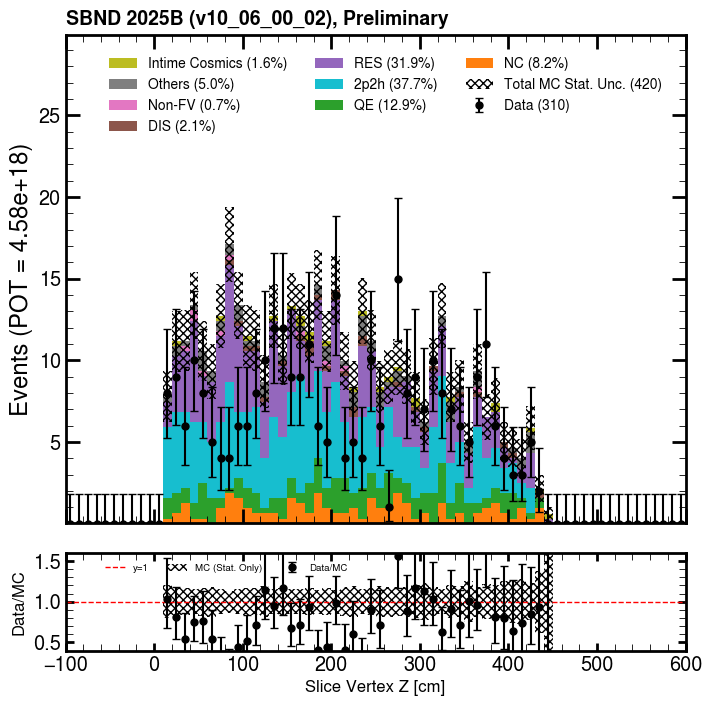

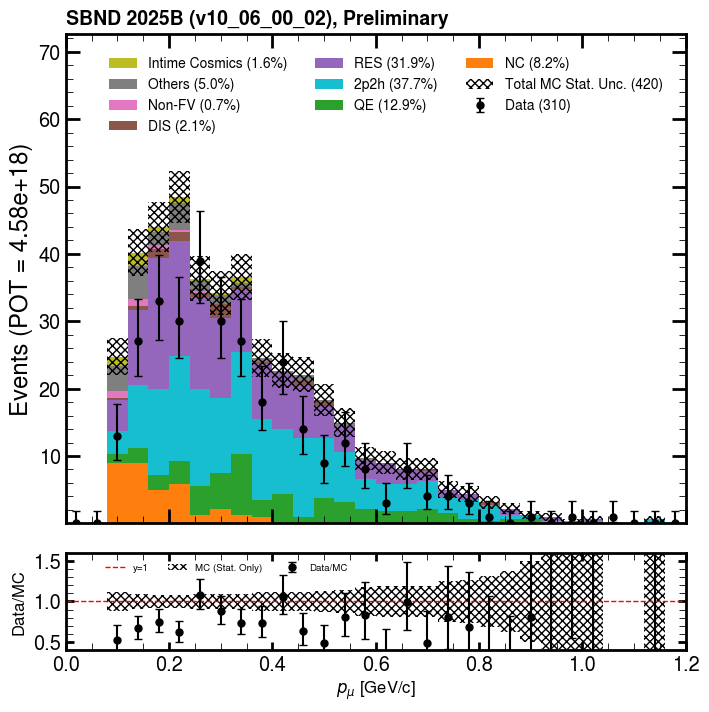

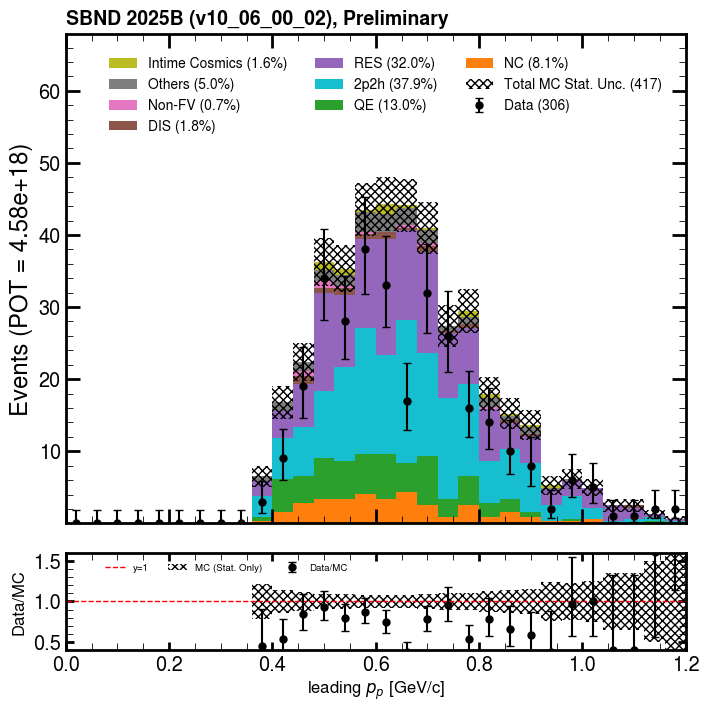

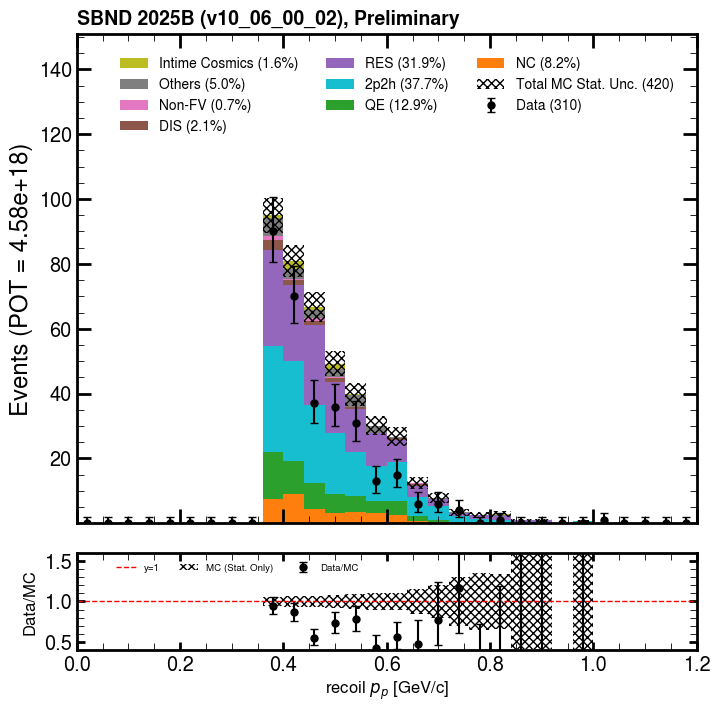

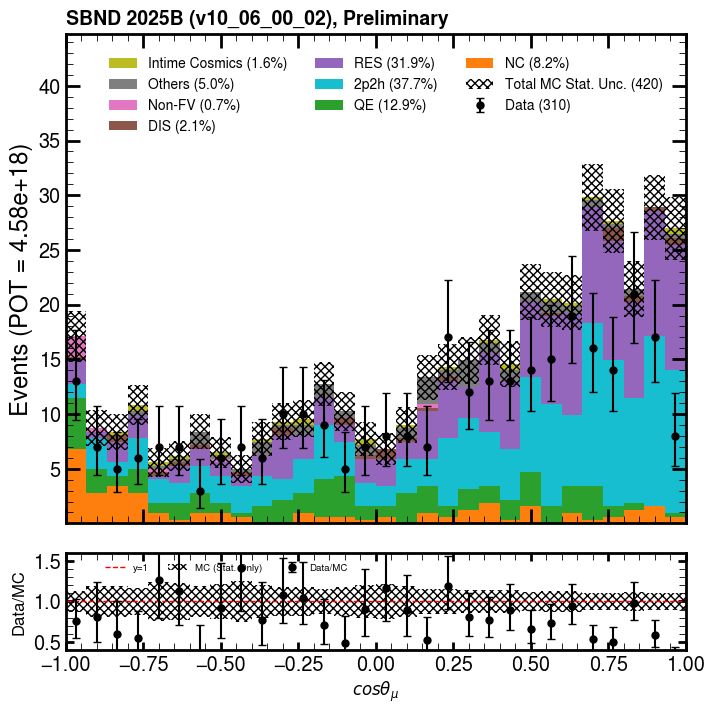

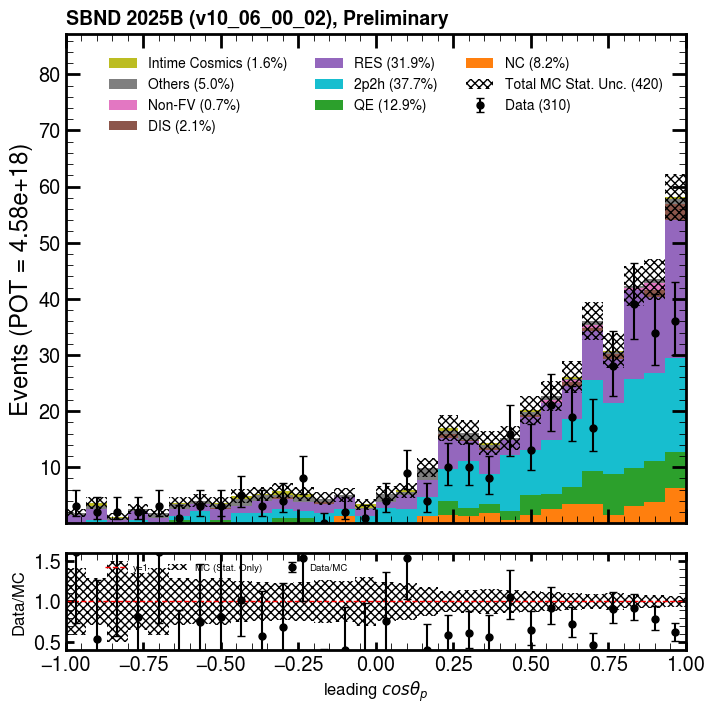

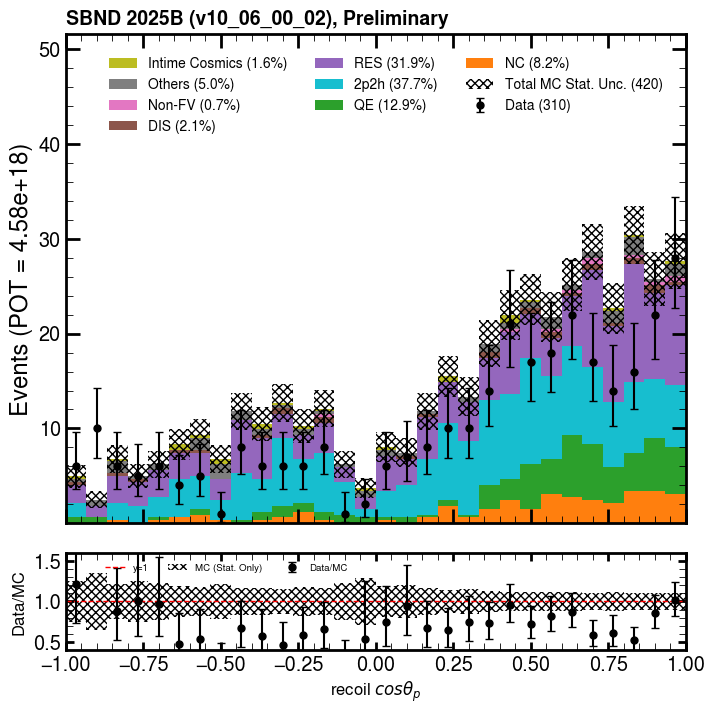

In [44]:
draw_reco_valid_plots(mc_reco_df, mc_intime_reco_df, data_reco_df, "containment")

In [45]:
mc_reco_df = mc_reco_df[ ( (mc_reco_df.pfp.trk.reco_pid == 13) & (mc_reco_df.pfp.trk.rangeP.p_muon > 0.1) ) | 
                         ( (mc_reco_df.pfp.trk.reco_pid == 2212) & (mc_reco_df.pfp.trk.rangeP.p_proton > 0.3) )]
mc_intime_reco_df = mc_intime_reco_df[ ( (mc_intime_reco_df.pfp.trk.reco_pid == 13) & (mc_intime_reco_df.pfp.trk.rangeP.p_muon > 0.1) ) | 
                        ( (mc_intime_reco_df.pfp.trk.reco_pid == 2212) & (mc_intime_reco_df.pfp.trk.rangeP.p_proton > 0.3) )]
data_reco_df = data_reco_df[ ( (data_reco_df.pfp.trk.reco_pid == 13) & (data_reco_df.pfp.trk.rangeP.p_muon > 0.1) ) | 
                        ( (data_reco_df.pfp.trk.reco_pid == 2212) & (data_reco_df.pfp.trk.rangeP.p_proton > 0.3) )]

#### exactly 3 pfps
mc_reco_df = pass_slc_with_n_pfps(mc_reco_df)
mc_intime_reco_df = pass_slc_with_n_pfps(mc_intime_reco_df)
data_reco_df = pass_slc_with_n_pfps(data_reco_df)

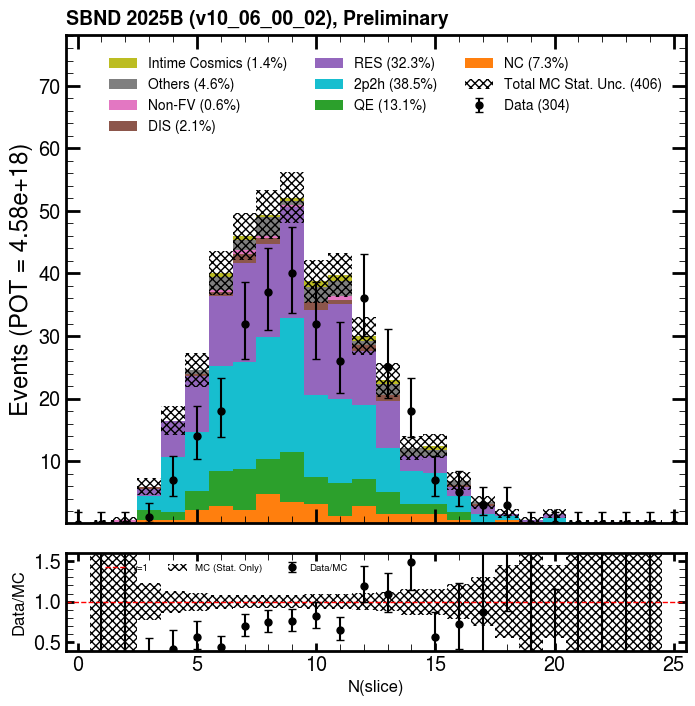

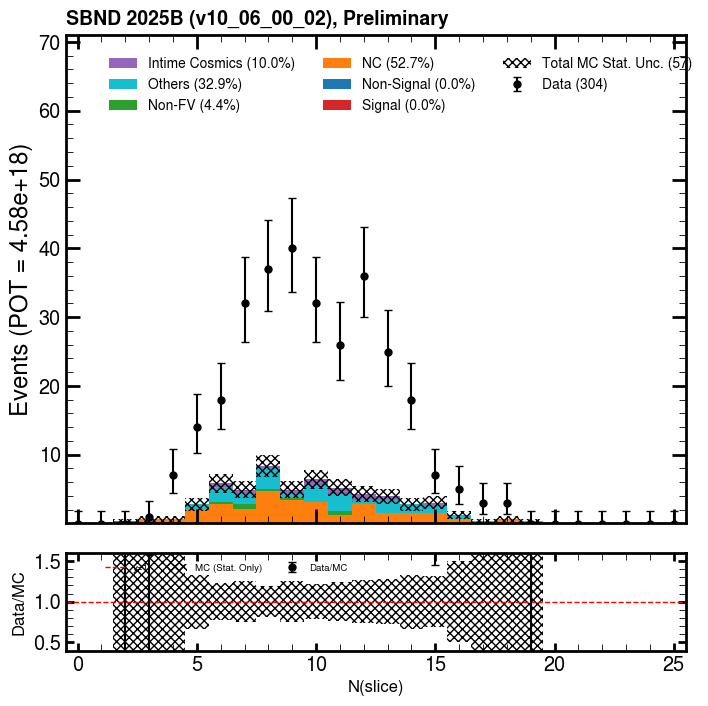

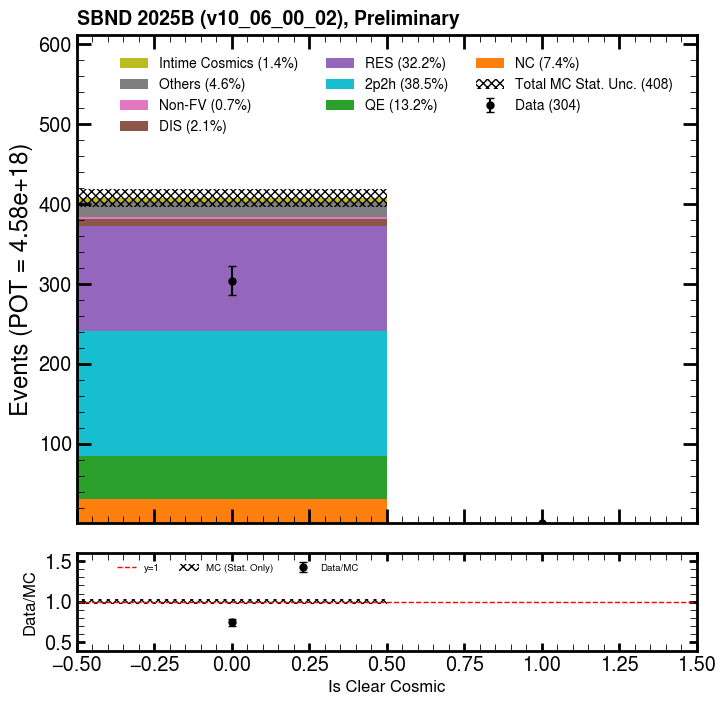

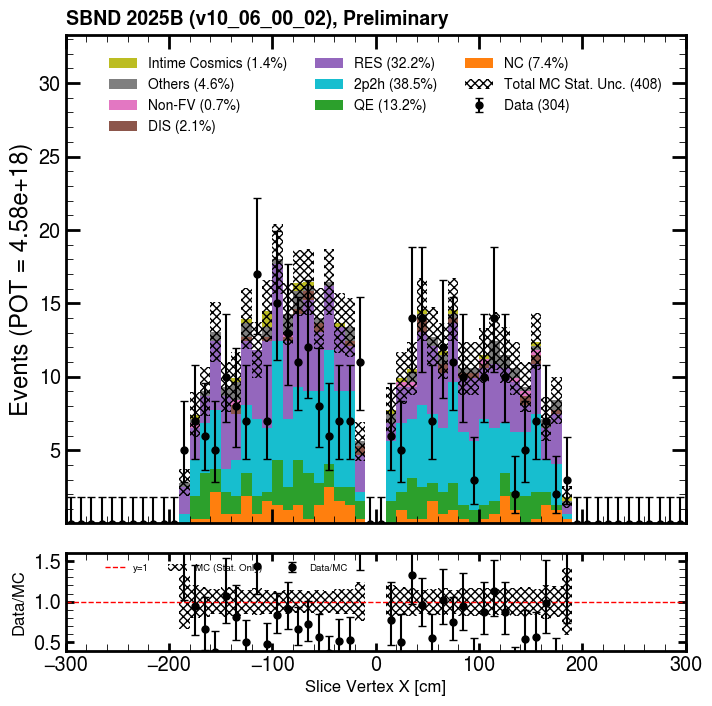

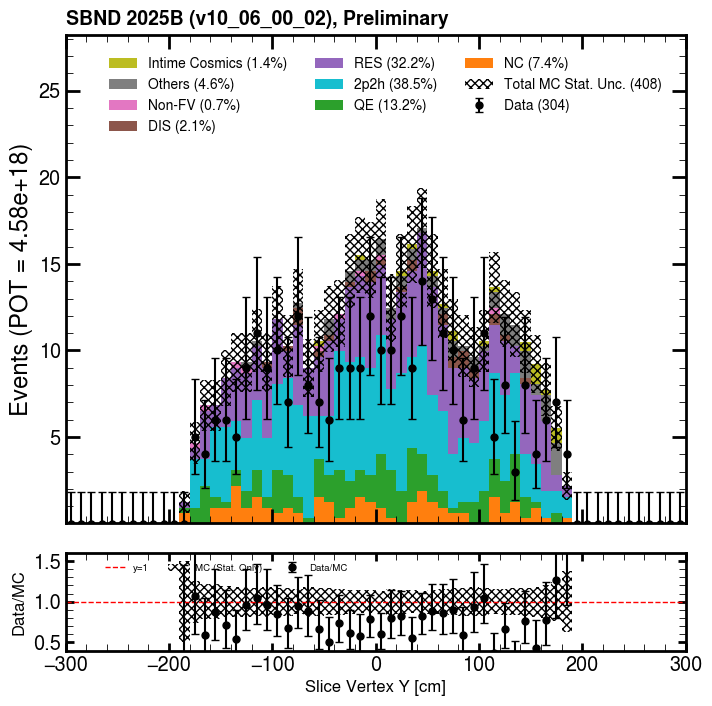

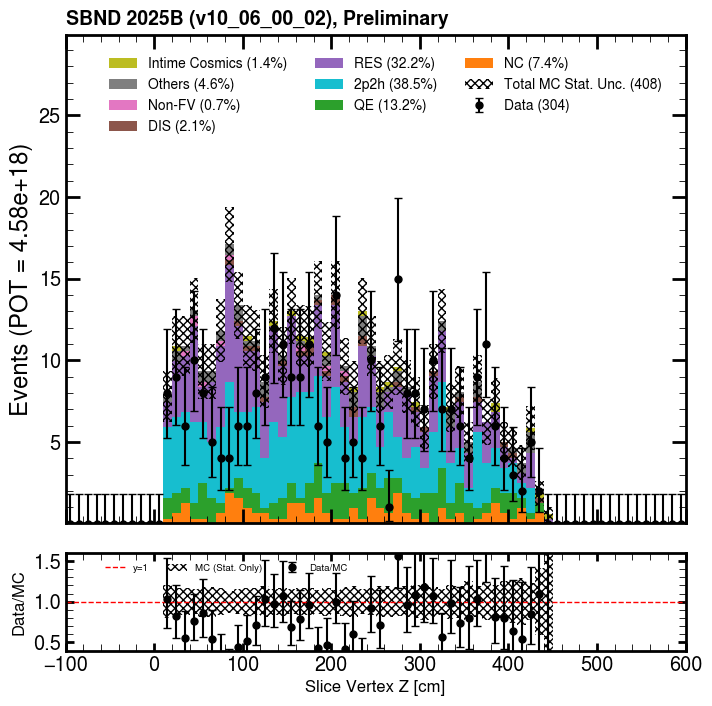

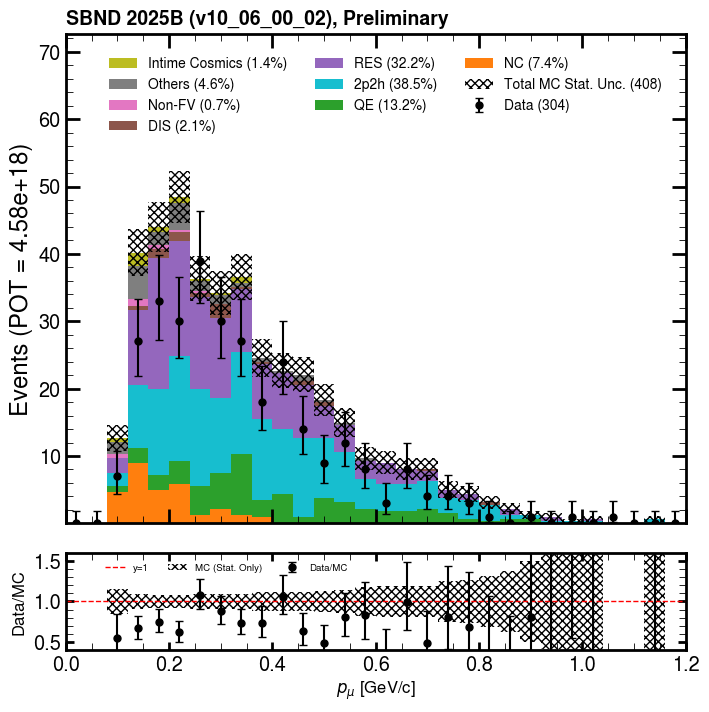

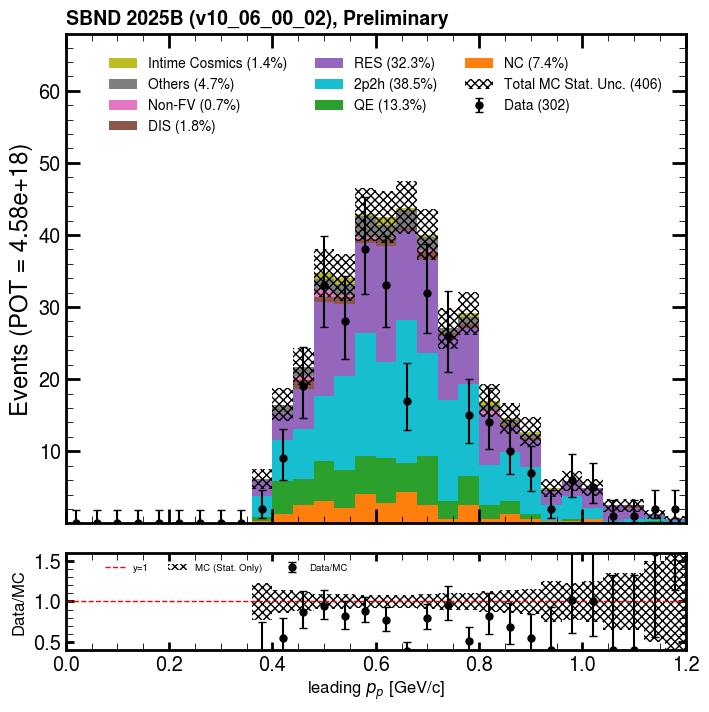

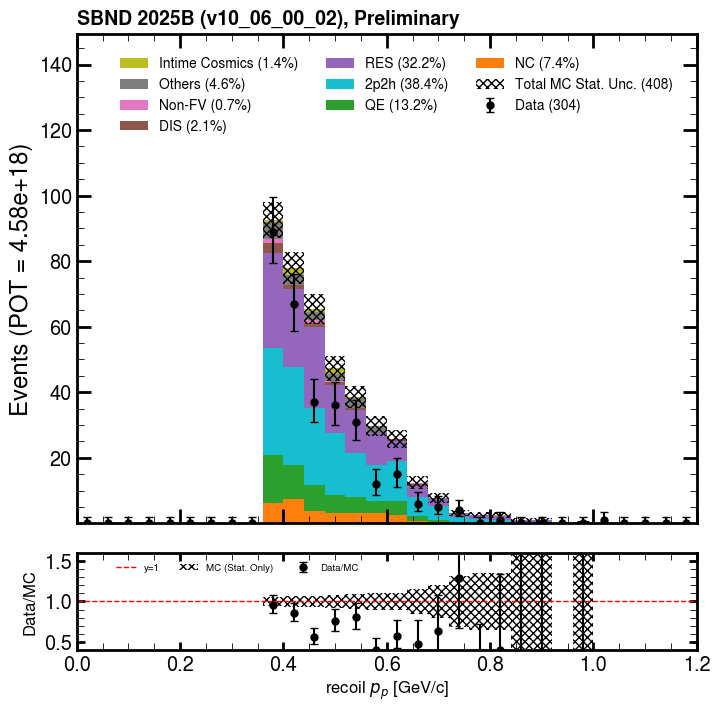

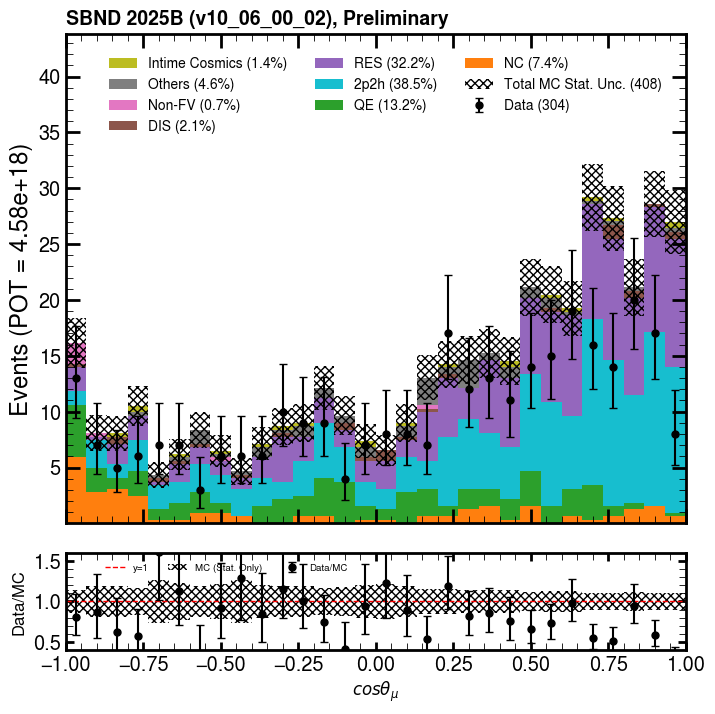

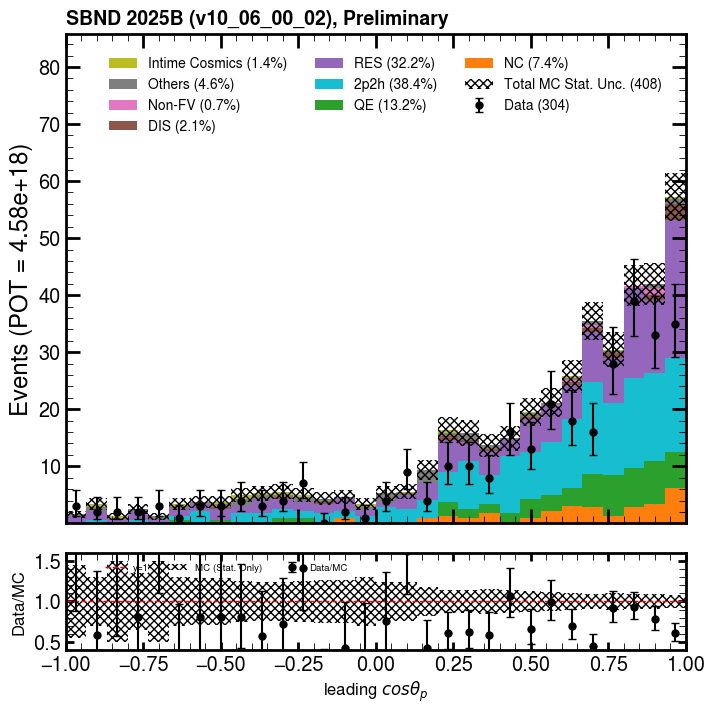

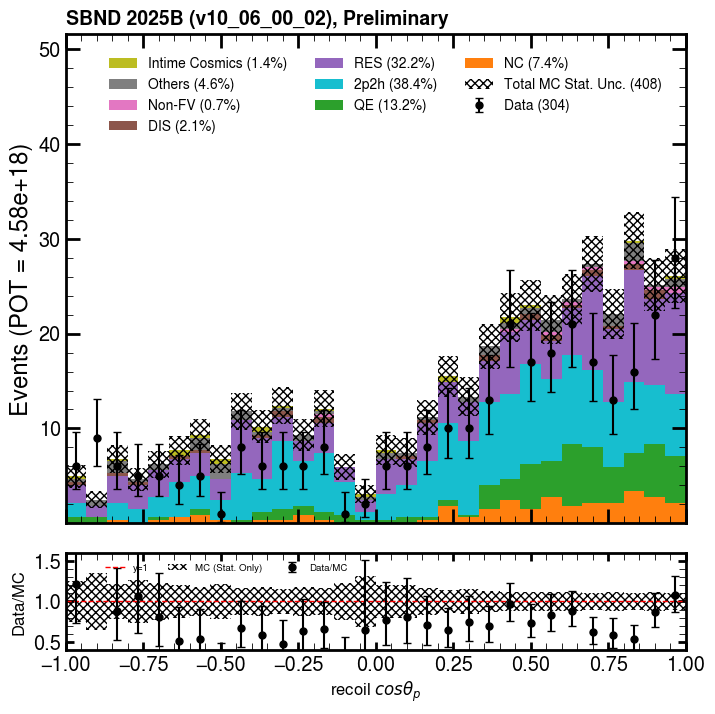

In [46]:
draw_reco_valid_plots(mc_reco_df, mc_intime_reco_df, data_reco_df, "h_trk_threshold")

In [47]:
mc_reco_imbalance_df = mc_reco_df.groupby(['__ntuple', 'entry', 'rec.slc..index']).apply(measure_reco_imbalance)

mc_reco_deltapt_series = mc_reco_imbalance_df['deltapt']
mc_reco_deltaalphat_series = mc_reco_imbalance_df['deltaalphat']
mc_reco_deltaphit_series = mc_reco_imbalance_df['deltaphit']
mc_reco_costheta_lr_series = mc_reco_imbalance_df['costheta_lr']
mc_reco_costheta_mu_sum_series = mc_reco_imbalance_df['costheta_mu_sum']
mc_reco_e_cal_series = mc_reco_imbalance_df['e_cal']
mc_reco_pn_series = mc_reco_imbalance_df['pn']
mc_reco_phi_3d_series = mc_reco_imbalance_df['phi_3d']
mc_reco_alpha_3d_series = mc_reco_imbalance_df['alpha_3d']

mc_reco_df[('reco_deltapt', '', '', '', '', '')] = mc_reco_deltapt_series
mc_reco_df[('reco_deltaalphat', '', '', '', '', '')] = mc_reco_deltaalphat_series
mc_reco_df[('reco_deltaphit', '', '', '', '', '')] = mc_reco_deltaphit_series
mc_reco_df[('reco_costheta_lr', '', '', '', '', '')] = mc_reco_costheta_lr_series
mc_reco_df[('reco_costheta_mu_sum', '', '', '', '', '')] = mc_reco_costheta_mu_sum_series
mc_reco_df[('reco_e_cal', '', '', '', '', '')] = mc_reco_e_cal_series
mc_reco_df[('reco_pn', '', '', '', '', '')] = mc_reco_pn_series
mc_reco_df[('reco_phi_3d', '', '', '', '', '')] = mc_reco_phi_3d_series
mc_reco_df[('reco_alpha_3d', '', '', '', '', '')] = mc_reco_alpha_3d_series

mc_intime_reco_imbalance_df = mc_intime_reco_df.groupby(['__ntuple', 'entry', 'rec.slc..index']).apply(measure_reco_imbalance)

mc_intime_reco_deltapt_series = mc_intime_reco_imbalance_df['deltapt']
mc_intime_reco_deltaalphat_series = mc_intime_reco_imbalance_df['deltaalphat']
mc_intime_reco_deltaphit_series = mc_intime_reco_imbalance_df['deltaphit']
mc_intime_reco_costheta_lr_series = mc_intime_reco_imbalance_df['costheta_lr']
mc_intime_reco_costheta_mu_sum_series = mc_intime_reco_imbalance_df['costheta_mu_sum']
mc_intime_reco_e_cal_series = mc_intime_reco_imbalance_df['e_cal']
mc_intime_reco_pn_series = mc_intime_reco_imbalance_df['pn']
mc_intime_reco_phi_3d_series = mc_intime_reco_imbalance_df['phi_3d']
mc_intime_reco_alpha_3d_series = mc_intime_reco_imbalance_df['alpha_3d']

mc_intime_reco_df[('reco_deltapt', '', '', '', '', '')] = mc_intime_reco_deltapt_series
mc_intime_reco_df[('reco_deltaalphat', '', '', '', '', '')] = mc_intime_reco_deltaalphat_series
mc_intime_reco_df[('reco_deltaphit', '', '', '', '', '')] = mc_intime_reco_deltaphit_series
mc_intime_reco_df[('reco_costheta_lr', '', '', '', '', '')] = mc_intime_reco_costheta_lr_series
mc_intime_reco_df[('reco_costheta_mu_sum', '', '', '', '', '')] = mc_intime_reco_costheta_mu_sum_series
mc_intime_reco_df[('reco_e_cal', '', '', '', '', '')] = mc_intime_reco_e_cal_series
mc_intime_reco_df[('reco_pn', '', '', '', '', '')] = mc_intime_reco_pn_series
mc_intime_reco_df[('reco_phi_3d', '', '', '', '', '')] = mc_intime_reco_phi_3d_series
mc_intime_reco_df[('reco_alpha_3d', '', '', '', '', '')] = mc_intime_reco_alpha_3d_series

data_reco_imbalance_df = data_reco_df.groupby(['__ntuple', 'entry', 'rec.slc..index']).apply(measure_reco_imbalance)

data_reco_deltapt_series = data_reco_imbalance_df['deltapt']
data_reco_deltaalphat_series = data_reco_imbalance_df['deltaalphat']
data_reco_deltaphit_series = data_reco_imbalance_df['deltaphit']
data_reco_costheta_lr_series = data_reco_imbalance_df['costheta_lr']
data_reco_costheta_mu_sum_series = data_reco_imbalance_df['costheta_mu_sum']
data_reco_e_cal_series = data_reco_imbalance_df['e_cal']
data_reco_pn_series = data_reco_imbalance_df['pn']
data_reco_phi_3d_series = data_reco_imbalance_df['phi_3d']
data_reco_alpha_3d_series = data_reco_imbalance_df['alpha_3d']

data_reco_df[('reco_deltapt', '', '', '', '', '')] = data_reco_deltapt_series
data_reco_df[('reco_deltaalphat', '', '', '', '', '')] = data_reco_deltaalphat_series
data_reco_df[('reco_deltaphit', '', '', '', '', '')] = data_reco_deltaphit_series
data_reco_df[('reco_costheta_lr', '', '', '', '', '')] = data_reco_costheta_lr_series
data_reco_df[('reco_costheta_mu_sum', '', '', '', '', '')] = data_reco_costheta_mu_sum_series
data_reco_df[('reco_e_cal', '', '', '', '', '')] = data_reco_e_cal_series
data_reco_df[('reco_pn', '', '', '', '', '')] = data_reco_pn_series
data_reco_df[('reco_phi_3d', '', '', '', '', '')] = data_reco_phi_3d_series
data_reco_df[('reco_alpha_3d', '', '', '', '', '')] = data_reco_alpha_3d_series

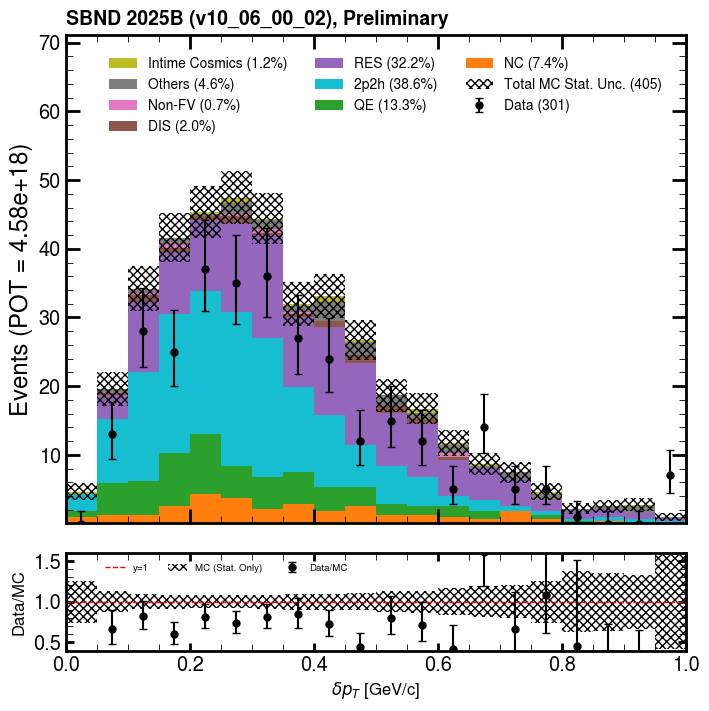

In [48]:
deltapt_col = ('reco_deltapt', '', '', '', '', '')
draw_mc_data_shape_comp_per_slc(mc_reco_df, mc_intime_reco_df, data_reco_df, deltapt_col, "$\\delta p_{T}$ [GeV/c]", "A.U.", 0., 1., 20, "_deltapt", False, False)

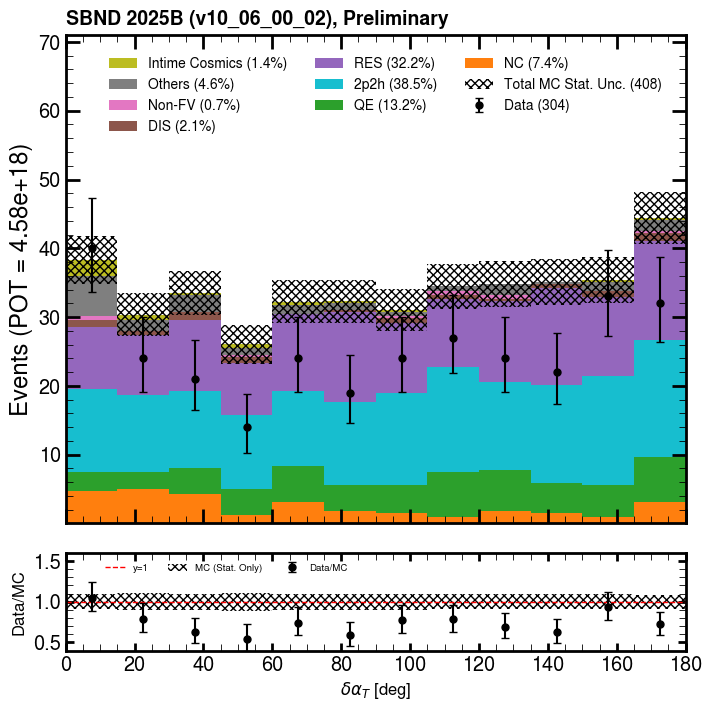

In [49]:
deltaalphat_col = ('reco_deltaalphat', '', '', '', '', '')
draw_mc_data_shape_comp_per_slc(mc_reco_df, mc_intime_reco_df, data_reco_df, deltaalphat_col, "$\\delta\\alpha_{T}$ [deg]", "A.U.", 0., 180., 12, "_deltaalphat", False, False)

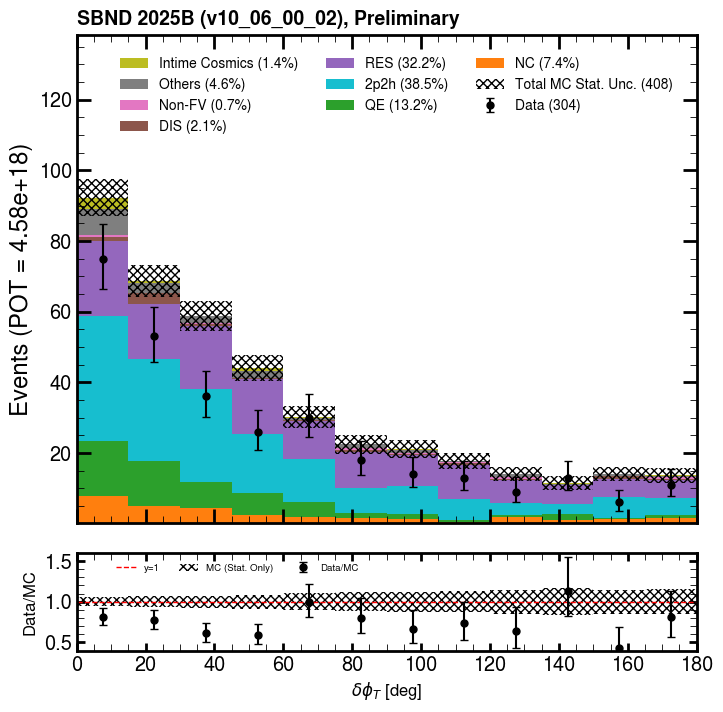

In [50]:
deltaphit_col = ('reco_deltaphit', '', '', '', '', '')
draw_mc_data_shape_comp_per_slc(mc_reco_df, mc_intime_reco_df, data_reco_df, deltaphit_col, "$\\delta\\phi_{T}$ [deg]", "A.U.", 0., 180., 12, "_deltaphit", False, False)

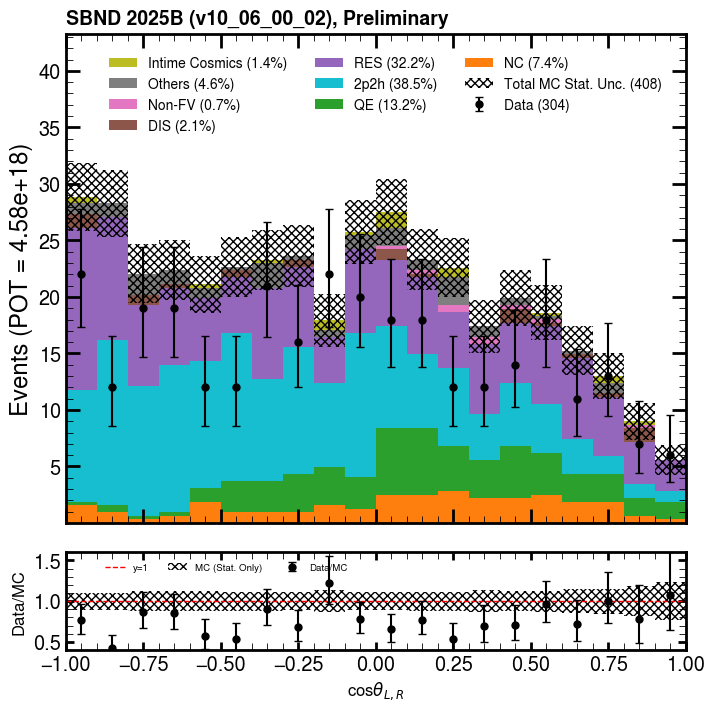

In [51]:
costheta_lr_col = ('reco_costheta_lr', '', '', '', '', '')
draw_mc_data_shape_comp_per_slc(mc_reco_df, mc_intime_reco_df, data_reco_df, costheta_lr_col, "cos$\\theta_{L,R}$", "A.U.", -1, 1., 20, "_costheta_lr", False, False)

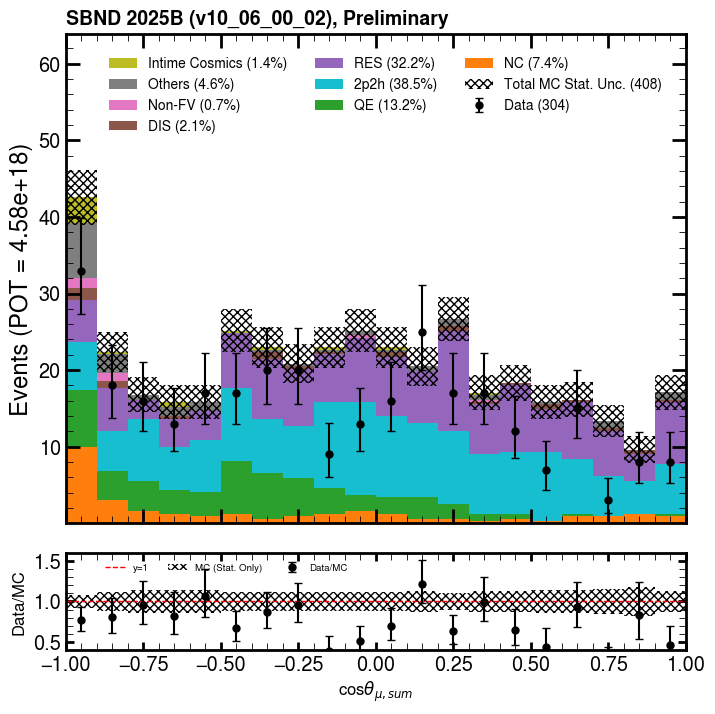

In [52]:
costheta_mu_sum_col = ('reco_costheta_mu_sum', '', '', '', '', '')
draw_mc_data_shape_comp_per_slc(mc_reco_df, mc_intime_reco_df, data_reco_df, costheta_mu_sum_col, "cos$\\theta_{\\mu,sum}$", "A.U.", -1, 1., 20, "_costheta_mu_sum", False, False)

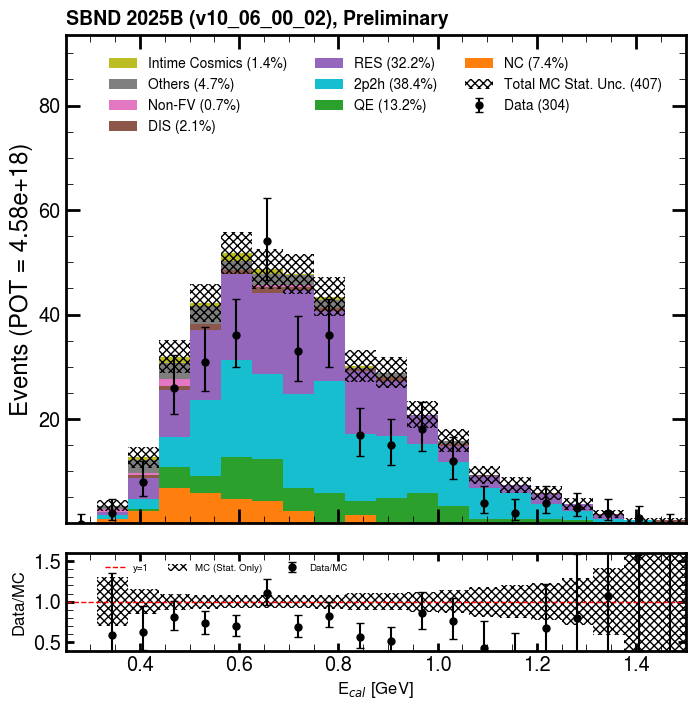

In [53]:
e_cal_col = ('reco_e_cal', '', '', '', '', '')
draw_mc_data_shape_comp_per_slc(mc_reco_df, mc_intime_reco_df, data_reco_df, e_cal_col, "E$_{cal}$ [GeV]", "A.U.", 0.25, 1.5, 20, "_e_cal", False, False)

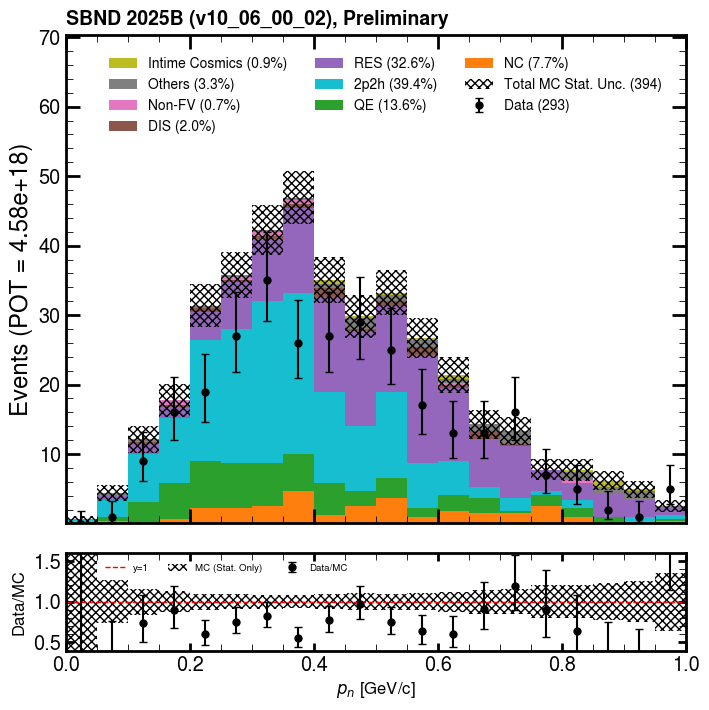

In [54]:
pn_col = ('reco_pn', '', '', '', '', '')
draw_mc_data_shape_comp_per_slc(mc_reco_df, mc_intime_reco_df, data_reco_df, pn_col, "$p_{n}$ [GeV/c]", "A.U.", 0., 1., 20, "_pn", False, False)

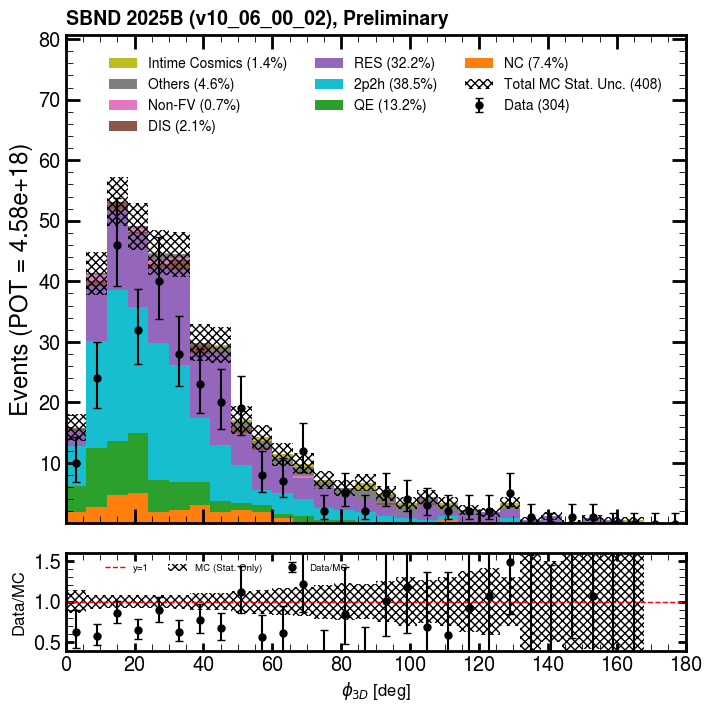

In [55]:
phi_3d_col = ('reco_phi_3d', '', '', '', '', '')
draw_mc_data_shape_comp_per_slc(mc_reco_df, mc_intime_reco_df, data_reco_df, phi_3d_col, "$\\phi_{3D}$ [deg]", "A.U.", 0., 180., 30, "_phi_3d", False, False)

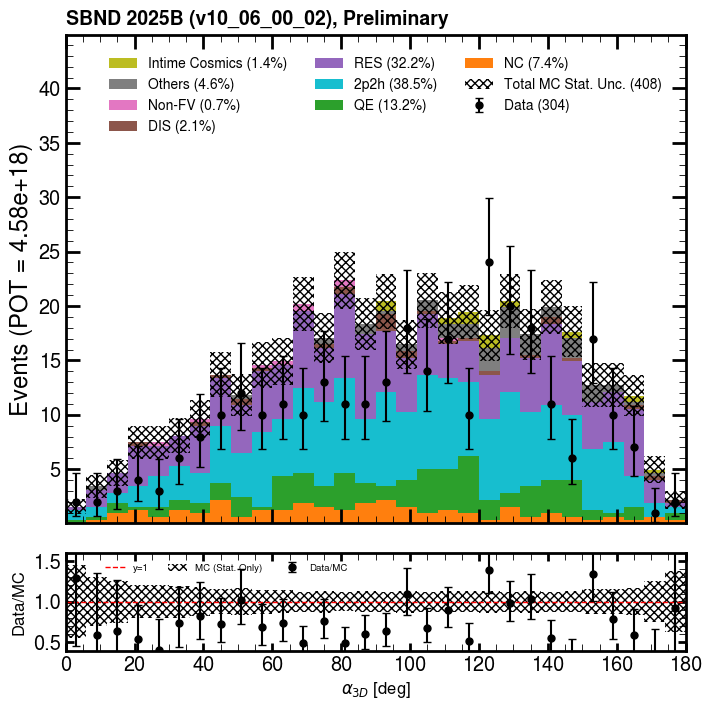

In [56]:
alpha_3d_col = ('reco_alpha_3d', '', '', '', '', '')
draw_mc_data_shape_comp_per_slc(mc_reco_df, mc_intime_reco_df, data_reco_df, alpha_3d_col, "$\\alpha_{3D}$ [deg]", "A.U.", 0., 180., 30, "_alpha_3d", False, False)